In [76]:
import pandas as pd
import numpy as np
import cobra
from Bio import SeqIO, Seq
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from cobra import Model, Reaction, Metabolite
from scipy.optimize import differential_evolution
import matplotlib.pyplot as plt
from cobra.io import write_sbml_model, save_matlab_model

In [ ]:
## import binary datasets

In [2]:
reaction_matrix = pd.read_csv("/home/users/lzehetner/data/hek/reaction_matrix.csv")

In [3]:
I_T_04 = ["lp_v1_tp2", "lp_v2_tp2", "lp_v3_tp2", "lp_v4_tp2"]
I_T_24 = ["lp_v1_tp3", "lp_v2_tp3", "lp_v3_tp3", "lp_v4_tp3"]
I_T_48 = ["lp_v1_tp4", "lp_v2_tp4", "lp_v3_tp4", "lp_v4_tp4"]
I_T_72 = ["lp_v1_tp5", "lp_v2_tp5", "lp_v3_tp5", "lp_v4_tp5"]

I_M_04 = ["lp_v5_tp2", "lp_v6_tp2", "lp_v7_tp2", "lp_v8_tp2"]
I_M_24 = ["lp_v5_tp3", "lp_v6_tp3", "lp_v7_tp3", "lp_v8_tp3"]
I_M_48 = ["lp_v5_tp4", "lp_v6_tp4", "lp_v7_tp4", "lp_v8_tp4"]
I_M_72 = ["lp_v5_tp5", "lp_v6_tp5", "lp_v7_tp5", "lp_v8_tp5"]

P_T_04 = ["hp_v1_tp2", "hp_v2_tp2", "hp_v3_tp2", "hp_v4_tp2"]
P_T_24 = ["hp_v1_tp3", "hp_v2_tp3", "hp_v3_tp3", "hp_v4_tp3"]
P_T_48 = ["hp_v1_tp4", "hp_v2_tp4", "hp_v3_tp4", "hp_v4_tp4"]
P_T_72 = ["hp_v1_tp5", "hp_v2_tp5", "hp_v3_tp5", "hp_v4_tp5"]

P_M_04 = ["hp_v5_tp2", "hp_v6_tp2", "hp_v7_tp2", "hp_v8_tp2"]
P_M_24 = ["hp_v5_tp3", "hp_v6_tp3", "hp_v7_tp3", "hp_v8_tp3"]
P_M_48 = ["hp_v5_tp4", "hp_v6_tp4", "hp_v7_tp4", "hp_v8_tp4"]
P_M_72 = ["hp_v5_tp5", "hp_v6_tp5", "hp_v8_tp5"]

In [335]:
input_rates = "/home/users/lzehetner/data/hek/specific_exchange_rates.csv"
df = pd.read_csv(input_rates)

In [336]:
df

,metabolite,state,time_point,qs,std_err,err_perc,ub,lb
0,Arginine,HP_TR,4,-0.009090,0.001231,-0.135456,-0.007859,-0.010321
1,Arginine,HP_TR,24,-0.002556,0.000286,-0.111989,-0.002270,-0.002842
2,Arginine,HP_TR,48,-0.000753,0.000109,-0.144984,-0.000644,-0.000862
3,Arginine,HP_TR,72,-0.000250,0.000060,-0.240459,-0.000190,-0.000310
4,Arginine,HP_MO,4,-0.011285,0.001426,-0.126329,-0.009859,-0.012710
...,...,...,...,...,...,...,...,...
507,Nh3,LP_TR,72,-0.005158,0.012798,-2.481274,0.007640,-0.017956
508,Nh3,LP_MO,4,0.013959,0.004104,0.294029,0.018064,0.009855
509,Nh3,LP_MO,24,-0.000980,0.003297,-3.363121,0.002317,-0.004278
510,Nh3,LP_MO,48,-0.004761,0.005941,-1.247729,0.001179,-0.010702


In [333]:
filtered_dfs = {}

In [6]:
states = ['HP_TR', 'HP_MO', 'LP_TR', 'LP_MO']
time_points = [4, 24, 48, 72]

In [7]:
for state in states:
    for time_point in time_points:
        key = f"{state}_{time_point}"
        filtered_dfs[key] = df[(df['state'] == state) & (df['time_point'] == time_point)]

In [8]:
df_hp_tr_4 = filtered_dfs['HP_TR_4']
df_hp_tr_24 = filtered_dfs['HP_TR_24']
df_hp_tr_48 = filtered_dfs['HP_TR_48']
df_hp_tr_72 = filtered_dfs['HP_TR_72']

df_hp_mo_4 = filtered_dfs['HP_MO_4']
df_hp_mo_24 = filtered_dfs['HP_MO_24']
df_hp_mo_48 = filtered_dfs['HP_MO_48']
df_hp_mo_72 = filtered_dfs['HP_MO_72']

df_lp_tr_4 = filtered_dfs['LP_TR_4']
df_lp_tr_24 = filtered_dfs['LP_TR_24']
df_lp_tr_48 = filtered_dfs['LP_TR_48']
df_lp_tr_72 = filtered_dfs['LP_TR_72']

df_lp_mo_4 = filtered_dfs['LP_MO_4']
df_lp_mo_24 = filtered_dfs['LP_MO_24']
df_lp_mo_48 = filtered_dfs['LP_MO_48']
df_lp_mo_72 = filtered_dfs['LP_MO_72']

In [9]:
# remove last row with ammonia, since there are no exchange rate fitted
df_hp_tr_72 = df_hp_tr_72[:-1]

In [10]:
metabolite_to_reaction = {'Alanine': 'MAR09061',
                         'Arginine': 'MAR09066',
                         'Asparagine': 'MAR09062',
                         'Aspartic acid': 'MAR09070',
                         'Glutamate': 'MAR09071',
                         'Glutamine': 'MAR09063',
                         'Gly': 'MAR09067',
                         'Histidine': 'MAR09038',
                         'Isoleucine': 'MAR09039',
                         'Leucine': 'MAR09040',
                         'Lysine': 'MAR09041',
                         'Methionine': 'MAR09042',
                         'Phenylalanine': 'MAR09043',
                         'Pro': 'MAR09068',
                         'Serine': 'MAR09069',
                         'Threonine': 'MAR09044',
                         'Tryptophan': 'MAR09045',
                         'Tyrosine': 'MAR09064',
                         'Valine': 'MAR09046',
                         'Glucose': 'MAR09034',
                         'Nh3': 'MAR11420',
                         'Lac': 'MAR09135'
                         }

In [11]:
input_model = "/home/users/lzehetner/data/human1/human1.xml"
mod = cobra.io.read_sbml_model(input_model)
mod.solver = "cplex"

In [343]:
print(len(mod.metabolites))

8370


In [13]:
min_media_comp = [
    "MAR09061",
    "MAR09034",
    "MAR09035",
    "MAR09036",
    "MAR09038",
    "MAR09039",
    "MAR09040",
    "MAR09041",
    "MAR09042",
    "MAR09043",
    "MAR09044",
    "MAR09045",
    "MAR09046",
    "MAR09047",
    "MAR09048",
    "MAR09062",
    "MAR09063",
    "MAR09064",
    "MAR09065",
    "MAR09066",
    "MAR09068",
    "MAR09069",
    "MAR09076",
    "MAR09146",
    "MAR09109",
    "MAR09143",
    "MAR09144",
    "MAR09147",
    "MAR09150",
    "MAR09151",
    "MAR09153",
    "MAR09158",
    "MAR09159",
    "MAR09167",
    "MAR09269",
    "MAR09072",
    "MAR09145",
    "MAR09070",
    "MAR09071",
    "MAR09067",
    "MAR11420",
    "MAR09135"
]

In [14]:
## AAV production reaction

In [15]:
##### Alanine reaction

ala_reaction = Reaction('MAR_ALA_nuc')
ala_reaction.name = 'Exchange reaction of alanine between cytosole and nucleus'
ala_reaction.subsystem = ''
ala_reaction.lower_bound = 0 # but needs to be adopted from paper
ala_reaction.upper_bound = 1000 # but needs also to be adopted

MAM01307n = Metabolite(
    'MAM01307n',
    formula= mod.metabolites.get_by_id("MAM01307c").formula,
    name='alanine',
    compartment='n')

ala_reaction.add_metabolites({
    mod.metabolites.get_by_id("MAM01307c"): -1, # Alanine
    MAM01307n: 1
})

##### Arginine reaction

arg_reaction = Reaction('MAR_ARG_nuc')
arg_reaction.name = 'Exchange reaction of arginine between cytosole and nucleus'
arg_reaction.subsystem = ''
arg_reaction.lower_bound = 0 # but needs to be adopted from paper
arg_reaction.upper_bound = 1000 # but needs also to be adopted

MAM01365n = Metabolite(
    'MAM01365n',
    formula= mod.metabolites.get_by_id("MAM01365c").formula,
    name='arginine',
    compartment='n')

arg_reaction.add_metabolites({
    mod.metabolites.get_by_id("MAM01365c"): -1, # Alanine
    MAM01365n: 1
})

##### Asparagine reaction

asn_reaction = Reaction('MAR_ASN_nuc')
asn_reaction.name = 'Exchange reaction of asparagine between cytosole and nucleus'
asn_reaction.subsystem = ''
asn_reaction.lower_bound = 0 # but needs to be adopted from paper
asn_reaction.upper_bound = 1000 # but needs also to be adopted

MAM01369n = Metabolite(
    'MAM01369n',
    formula= mod.metabolites.get_by_id("MAM01369c").formula,
    name='asparagine',
    compartment='n')

asn_reaction.add_metabolites({
    mod.metabolites.get_by_id("MAM01369c"): -1, # Alanine
    MAM01369n: 1
})

##### Aspartate reaction

asp_reaction = Reaction('MAR_ASP_nuc')
asp_reaction.name = 'Exchange reaction of aspartate between cytosole and nucleus'
asp_reaction.subsystem = ''
asp_reaction.lower_bound = 0 # but needs to be adopted from paper
asp_reaction.upper_bound = 1000 # but needs also to be adopted

MAM01370n = Metabolite(
    'MAM01370n',
    formula= mod.metabolites.get_by_id("MAM01370c").formula,
    name='aspartate',
    compartment='n')

asp_reaction.add_metabolites({
    mod.metabolites.get_by_id("MAM01370c"): -1, # Alanine
    MAM01370n: 1
})

##### Cysteine reaction

cys_reaction = Reaction('MAR_CYS_nuc')
cys_reaction.name = 'Exchange reaction of cysteine between cytosole and nucleus'
cys_reaction.subsystem = ''
cys_reaction.lower_bound = 0 # but needs to be adopted from paper
cys_reaction.upper_bound = 1000 # but needs also to be adopted

MAM01628n = Metabolite(
    'MAM01628n',
    formula= mod.metabolites.get_by_id("MAM01628c").formula,
    name='cysteine',
    compartment='n')

cys_reaction.add_metabolites({
    mod.metabolites.get_by_id("MAM01628c"): -1, # Alanine
    MAM01628n: 1
})

##### Glutamine reaction

gln_reaction = Reaction('MAR_GLN_nuc')
gln_reaction.name = 'Exchange reaction of glutamine between cytosole and nucleus'
gln_reaction.subsystem = ''
gln_reaction.lower_bound = 0 # but needs to be adopted from paper
gln_reaction.upper_bound = 1000 # but needs also to be adopted

MAM01975n = Metabolite(
    'MAM01975n',
    formula= mod.metabolites.get_by_id("MAM01975c").formula,
    name='glutamine',
    compartment='n')

gln_reaction.add_metabolites({
    mod.metabolites.get_by_id("MAM01975c"): -1, # Alanine
    MAM01975n: 1
})

##### Glutamate reaction

glu_reaction = Reaction('MAR_GLU_nuc')
glu_reaction.name = 'Exchange reaction of glutamate between cytosole and nucleus'
glu_reaction.subsystem = ''
glu_reaction.lower_bound = 0 # but needs to be adopted from paper
glu_reaction.upper_bound = 1000 # but needs also to be adopted

MAM01974n = Metabolite(
    'MAM01974n',
    formula= mod.metabolites.get_by_id("MAM01974c").formula,
    name='glutamate',
    compartment='n')

glu_reaction.add_metabolites({
    mod.metabolites.get_by_id("MAM01974c"): -1, # Alanine
    MAM01974n: 1
})

##### Glycine reaction

gly_reaction = Reaction('MAR_GLY_nuc')
gly_reaction.name = 'Exchange reaction of glycine between cytosole and nucleus'
gly_reaction.subsystem = ''
gly_reaction.lower_bound = 0 # but needs to be adopted from paper
gly_reaction.upper_bound = 1000 # but needs also to be adopted

MAM01986n = Metabolite(
    'MAM01986n',
    formula= mod.metabolites.get_by_id("MAM01986c").formula,
    name='glycine',
    compartment='n')

gly_reaction.add_metabolites({
    mod.metabolites.get_by_id("MAM01986c"): -1, # Alanine
    MAM01986n: 1
})

##### Histidine reaction

his_reaction = Reaction('MAR_HIS_nuc')
his_reaction.name = 'Exchange reaction of histidine between cytosole and nucleus'
his_reaction.subsystem = ''
his_reaction.lower_bound = 0 # but needs to be adopted from paper
his_reaction.upper_bound = 1000 # but needs also to be adopted

MAM02125n = Metabolite(
    'MAM02125n',
    formula= mod.metabolites.get_by_id("MAM02125c").formula,
    name='histidine',
    compartment='n')

his_reaction.add_metabolites({
    mod.metabolites.get_by_id("MAM02125c"): -1, # Alanine
    MAM02125n: 1
})

##### Isoleucine reaction

ile_reaction = Reaction('MAR_ILE_nuc')
ile_reaction.name = 'Exchange reaction of isoleucine between cytosole and nucleus'
ile_reaction.subsystem = ''
ile_reaction.lower_bound = 0 # but needs to be adopted from paper
ile_reaction.upper_bound = 1000 # but needs also to be adopted

MAM02184n = Metabolite(
    'MAM02184n',
    formula= mod.metabolites.get_by_id("MAM02184c").formula,
    name='isoleucine',
    compartment='n')

ile_reaction.add_metabolites({
    mod.metabolites.get_by_id("MAM02184c"): -1, # Alanine
    MAM02184n: 1
})

##### Leucine reaction

leu_reaction = Reaction('MAR_LEU_nuc')
leu_reaction.name = 'Exchange reaction of leucine between cytosole and nucleus'
leu_reaction.subsystem = ''
leu_reaction.lower_bound = 0 # but needs to be adopted from paper
leu_reaction.upper_bound = 1000 # but needs also to be adopted

MAM02360n = Metabolite(
    'MAM02360n',
    formula= mod.metabolites.get_by_id("MAM02360c").formula,
    name='leucine',
    compartment='n')

leu_reaction.add_metabolites({
    mod.metabolites.get_by_id("MAM02360c"): -1, # Alanine
    MAM02360n: 1
})

##### Lysine reaction

lys_reaction = Reaction('MAR_LYS_nuc')
lys_reaction.name = 'Exchange reaction of lysine between cytosole and nucleus'
lys_reaction.subsystem = ''
lys_reaction.lower_bound = 0 # but needs to be adopted from paper
lys_reaction.upper_bound = 1000 # but needs also to be adopted

MAM02426n = Metabolite(
    'MAM02426n',
    formula= mod.metabolites.get_by_id("MAM02426c").formula,
    name='lysine',
    compartment='n')

lys_reaction.add_metabolites({
    mod.metabolites.get_by_id("MAM02426c"): -1,
    MAM02426n: 1
})

##### Methionine reaction

met_reaction = Reaction('MAR_MET_nuc')
met_reaction.name = 'Exchange reaction of methionine between cytosole and nucleus'
met_reaction.subsystem = ''
met_reaction.lower_bound = 0 # but needs to be adopted from paper
met_reaction.upper_bound = 1000 # but needs also to be adopted

MAM02471n = Metabolite(
    'MAM02471n',
    formula= mod.metabolites.get_by_id("MAM02471c").formula,
    name='methionine',
    compartment='n')

met_reaction.add_metabolites({
    mod.metabolites.get_by_id("MAM02471c"): -1,
    MAM02471n: 1
})

##### Phenylalanine reaction

phe_reaction = Reaction('MAR_PHE_nuc')
phe_reaction.name = 'Exchange reaction of phenylalanine between cytosole and nucleus'
phe_reaction.subsystem = ''
phe_reaction.lower_bound = 0 # but needs to be adopted from paper
phe_reaction.upper_bound = 1000 # but needs also to be adopted

MAM02724n = Metabolite(
    'MAM02724n',
    formula= mod.metabolites.get_by_id("MAM02724c").formula,
    name='phenylalanine',
    compartment='n')

phe_reaction.add_metabolites({
    mod.metabolites.get_by_id("MAM02724c"): -1,
    MAM02724n: 1
})

##### Proline reaction

pro_reaction = Reaction('MAR_PRO_nuc')
pro_reaction.name = 'Exchange reaction of proline between cytosole and nucleus'
pro_reaction.subsystem = ''
pro_reaction.lower_bound = 0 # but needs to be adopted from paper
pro_reaction.upper_bound = 1000 # but needs also to be adopted

MAM02770n = Metabolite(
    'MAM02770n',
    formula= mod.metabolites.get_by_id("MAM02770c").formula,
    name='proline',
    compartment='n')

pro_reaction.add_metabolites({
    mod.metabolites.get_by_id("MAM02770c"): -1,
    MAM02770n: 1
})

##### Serine reaction

ser_reaction = Reaction('MAR_SER_nuc')
ser_reaction.name = 'Exchange reaction of serine between cytosole and nucleus'
ser_reaction.subsystem = ''
ser_reaction.lower_bound = 0 # but needs to be adopted from paper
ser_reaction.upper_bound = 1000 # but needs also to be adopted

MAM02896n = Metabolite(
    'MAM02896n',
    formula= mod.metabolites.get_by_id("MAM02896c").formula,
    name='serine',
    compartment='n')

ser_reaction.add_metabolites({
    mod.metabolites.get_by_id("MAM02896c"): -1,
    MAM02896n: 1
})

##### Threonine reaction

thr_reaction = Reaction('MAR_THR_nuc')
thr_reaction.name = 'Exchange reaction of threonine between cytosole and nucleus'
thr_reaction.subsystem = ''
thr_reaction.lower_bound = 0 # but needs to be adopted from paper
thr_reaction.upper_bound = 1000 # but needs also to be adopted

MAM02993n = Metabolite(
    'MAM02993n',
    formula= mod.metabolites.get_by_id("MAM02993c").formula,
    name='threonine',
    compartment='n')

thr_reaction.add_metabolites({
    mod.metabolites.get_by_id("MAM02993c"): -1,
    MAM02993n: 1
})

##### Tryptophane reaction

trp_reaction = Reaction('MAR_TRP_nuc')
trp_reaction.name = 'Exchange reaction of tryptophane between cytosole and nucleus'
trp_reaction.subsystem = ''
trp_reaction.lower_bound = 0 # but needs to be adopted from paper
trp_reaction.upper_bound = 1000 # but needs also to be adopted

MAM03089n = Metabolite(
    'MAM03089n',
    formula= mod.metabolites.get_by_id("MAM03089c").formula,
    name='tryptophane',
    compartment='n')

trp_reaction.add_metabolites({
    mod.metabolites.get_by_id("MAM03089c"): -1,
    MAM03089n: 1
})

##### Tyrosine reaction

tyr_reaction = Reaction('MAR_TYR_nuc')
tyr_reaction.name = 'Exchange reaction of tyrosine between cytosole and nucleus'
tyr_reaction.subsystem = ''
tyr_reaction.lower_bound = 0 # but needs to be adopted from paper
tyr_reaction.upper_bound = 1000 # but needs also to be adopted

MAM03101n = Metabolite(
    'MAM03101n',
    formula= mod.metabolites.get_by_id("MAM03101c").formula,
    name='tyrosine',
    compartment='n')

tyr_reaction.add_metabolites({
    mod.metabolites.get_by_id("MAM03101c"): -1,
    MAM03101n: 1
})

##### Valine reaction

val_reaction = Reaction('MAR_VAL_nuc')
val_reaction.name = 'Exchange reaction of valine between cytosole and nucleus'
val_reaction.subsystem = ''
val_reaction.lower_bound = 0 # but needs to be adopted from paper
val_reaction.upper_bound = 1000 # but needs also to be adopted

MAM03135n = Metabolite(
    'MAM03135n',
    formula= mod.metabolites.get_by_id("MAM03135c").formula,
    name='valine',
    compartment='n')

val_reaction.add_metabolites({
    mod.metabolites.get_by_id("MAM03135c"): -1,
    MAM03135n: 1
})

In [16]:
# the file was downloaded from ncbi db
infile = open("/home/users/lzehetner/sequence_1.fasta")

aav_dict = SeqIO.to_dict(SeqIO.parse(infile, "fasta"))
# print(aav_dict)
vp1_seq = aav_dict["YP_077180.1"].seq
vp2_seq = aav_dict["YP_077180.2"].seq
vp3_seq = aav_dict["YP_077180.3"].seq

In [17]:
vp1_counts = {
    "A": vp1_seq.count('A'),
    "R": vp1_seq.count('R'),
    "N": vp1_seq.count('N'),
    "D": vp1_seq.count('D'),
    "C": vp1_seq.count('C'),
    "Q": vp1_seq.count('Q'),
    "E": vp1_seq.count('E'),
    "G": vp1_seq.count('G'),
    "H": vp1_seq.count('H'),
    "I": vp1_seq.count('I'),
    "L": vp1_seq.count('L'),
    "K": vp1_seq.count('K'),
    "M": vp1_seq.count('M'),
    "F": vp1_seq.count('F'),
    "P": vp1_seq.count('P'),
    "S": vp1_seq.count('S'),
    "T": vp1_seq.count('T'),
    "W": vp1_seq.count('W'),
    "Y": vp1_seq.count('Y'),
    "V": vp1_seq.count('V'),
}

vp2_counts = {
    "A": vp2_seq.count('A'),
    "R": vp2_seq.count('R'),
    "N": vp2_seq.count('N'),
    "D": vp2_seq.count('D'),
    "C": vp2_seq.count('C'),
    "Q": vp2_seq.count('Q'),
    "E": vp2_seq.count('E'),
    "G": vp2_seq.count('G'),
    "H": vp2_seq.count('H'),
    "I": vp2_seq.count('I'),
    "L": vp2_seq.count('L'),
    "K": vp2_seq.count('K'),
    "M": vp2_seq.count('M'),
    "F": vp2_seq.count('F'),
    "P": vp2_seq.count('P'),
    "S": vp2_seq.count('S'),
    "T": vp2_seq.count('T'),
    "W": vp2_seq.count('W'),
    "Y": vp2_seq.count('Y'),
    "V": vp2_seq.count('V'),
}

vp3_counts = {
    "A": vp3_seq.count('A'),
    "R": vp3_seq.count('R'),
    "N": vp3_seq.count('N'),
    "D": vp3_seq.count('D'),
    "C": vp3_seq.count('C'),
    "Q": vp3_seq.count('Q'),
    "E": vp3_seq.count('E'),
    "G": vp3_seq.count('G'),
    "H": vp3_seq.count('H'),
    "I": vp3_seq.count('I'),
    "L": vp3_seq.count('L'),
    "K": vp3_seq.count('K'),
    "M": vp3_seq.count('M'),
    "F": vp3_seq.count('F'),
    "P": vp3_seq.count('P'),
    "S": vp3_seq.count('S'),
    "T": vp3_seq.count('T'),
    "W": vp3_seq.count('W'),
    "Y": vp3_seq.count('Y'),
    "V": vp3_seq.count('V'),
}

print("VP1: ", vp1_counts)
print("VP2: ", vp2_counts)
print("VP3: ", vp3_counts)

VP1:  {'A': 51, 'R': 31, 'N': 58, 'D': 37, 'C': 5, 'Q': 48, 'E': 34, 'G': 69, 'H': 14, 'I': 24, 'L': 53, 'K': 32, 'M': 11, 'F': 32, 'P': 57, 'S': 49, 'T': 55, 'W': 15, 'Y': 33, 'V': 30}
VP2:  {'A': 34, 'R': 25, 'N': 51, 'D': 25, 'C': 5, 'Q': 39, 'E': 23, 'G': 54, 'H': 12, 'I': 23, 'L': 37, 'K': 22, 'M': 10, 'F': 28, 'P': 48, 'S': 47, 'T': 54, 'W': 12, 'Y': 27, 'V': 25}
VP3:  {'A': 30, 'R': 21, 'N': 49, 'D': 22, 'C': 5, 'Q': 34, 'E': 20, 'G': 45, 'H': 12, 'I': 22, 'L': 35, 'K': 17, 'M': 10, 'F': 27, 'P': 35, 'S': 40, 'T': 50, 'W': 12, 'Y': 27, 'V': 22}


In [18]:
aa_compositions = {
    'A': {'C': 3, 'H': 7, 'O': 2, 'N': 1, 'S': 0},
    'C': {'C': 3, 'H': 7, 'O': 2, 'N': 1, 'S': 1},
    'D': {'C': 4, 'H': 7, 'O': 4, 'N': 1, 'S': 0},
    'E': {'C': 5, 'H': 9, 'O': 4, 'N': 1, 'S': 0},
    'F': {'C': 9, 'H': 11, 'O': 2, 'N': 1, 'S': 0},
    'G': {'C': 2, 'H': 5, 'O': 2, 'N': 1, 'S': 0},
    'H': {'C': 6, 'H': 9, 'O': 2, 'N': 3, 'S': 0},
    'I': {'C': 6, 'H': 13,'O': 2, 'N': 1, 'S': 0},
    'K': {'C': 6, 'H': 14,'O': 2, 'N': 2, 'S': 0},
    'L': {'C': 6, 'H': 13,'O': 2, 'N': 1, 'S': 0},
    'M': {'C': 5, 'H': 11, 'O': 2, 'N': 1, 'S': 1},
    'N': {'C': 4, 'H': 8, 'O': 3, 'N': 2, 'S': 0},
    'P': {'C': 5, 'H': 9, 'O': 2, 'N': 1, 'S': 0},
    'Q': {'C': 5, 'H': 10, 'O': 3, 'N': 2, 'S': 0},
    'R': {'C': 6, 'H': 14,'O': 2, 'N': 4, 'S': 0},
    'S': {'C': 3, 'H': 7, 'O': 3, 'N': 1, 'S': 0},
    'T': {'C': 4, 'H': 9, 'O': 3, 'N': 1, 'S': 0},
    'V': {'C': 5, 'H': 11, 'O': 2, 'N': 1, 'S': 0},
    'W': {'C': 11,'H': 12,'O': 2, 'N': 2, 'S': 0},
    'Y': {'C': 9, 'H': 11, 'O': 3, 'N': 1, 'S': 0},
}

# VP1
protein_seq = str(vp1_seq)
analysis = ProteinAnalysis(protein_seq)

# Count amino acids in the protein sequence
aa_counts = analysis.count_amino_acids()

# Calculate the sum formula based on atomic composition
sum_formula_counts = {'C': 0, 'H': 0, 'O': 0, 'N': 0, 'S': 0}

for aa, count in aa_counts.items():
    for atom, atom_count in aa_compositions[aa].items():
        sum_formula_counts[atom] += atom_count * count

# Adjust for the released water molecules during peptide bond formation
num_peptide_bonds = len(protein_seq) - 1
sum_formula_counts['H'] -= 2 * num_peptide_bonds
sum_formula_counts['O'] -= num_peptide_bonds

# Create the sum formula string
sum_formula_vp1 = "".join([f"{atom}{count}" for atom, count in sum_formula_counts.items()])
print(f"Sum Formula: {sum_formula_vp1}")

# VP2
protein_seq = str(vp2_seq)
analysis = ProteinAnalysis(protein_seq)

# Count amino acids in the protein sequence
aa_counts = analysis.count_amino_acids()

# Calculate the sum formula based on atomic composition
sum_formula_counts = {'C': 0, 'H': 0, 'O': 0, 'N': 0, 'S': 0}

for aa, count in aa_counts.items():
    for atom, atom_count in aa_compositions[aa].items():
        sum_formula_counts[atom] += atom_count * count

# Adjust for the released water molecules during peptide bond formation
num_peptide_bonds = len(protein_seq) - 1
sum_formula_counts['H'] -= 2 * num_peptide_bonds
sum_formula_counts['O'] -= num_peptide_bonds

# Create the sum formula string
sum_formula_vp2 = "".join([f"{atom}{count}" for atom, count in sum_formula_counts.items()])
print(f"Sum Formula: {sum_formula_vp2}")

# VP3
protein_seq = str(vp3_seq)
analysis = ProteinAnalysis(protein_seq)

# Count amino acids in the protein sequence
aa_counts = analysis.count_amino_acids()

# Calculate the sum formula based on atomic composition
sum_formula_counts = {'C': 0, 'H': 0, 'O': 0, 'N': 0, 'S': 0}

for aa, count in aa_counts.items():
    for atom, atom_count in aa_compositions[aa].items():
        sum_formula_counts[atom] += atom_count * count

# Adjust for the released water molecules during peptide bond formation
num_peptide_bonds = len(protein_seq) - 1
sum_formula_counts['H'] -= 2 * num_peptide_bonds
sum_formula_counts['O'] -= num_peptide_bonds

# Create the sum formula string
sum_formula_vp3 = "".join([f"{atom}{count}" for atom, count in sum_formula_counts.items()])
print(f"Sum Formula: {sum_formula_vp3}")




protein_seq = 5 * str(vp1_seq) + 5 * str(vp2_seq) + 50 * str(vp3_seq)
analysis = ProteinAnalysis(protein_seq)

# Count amino acids in the protein sequence
aa_counts = analysis.count_amino_acids()

# Calculate the sum formula based on atomic composition
sum_formula_counts = {'C': 0, 'H': 0, 'O': 0, 'N': 0, 'S': 0}

for aa, count in aa_counts.items():
    for atom, atom_count in aa_compositions[aa].items():
        sum_formula_counts[atom] += atom_count * count

# Adjust for the released water molecules during peptide bond formation
num_peptide_bonds = len(protein_seq) - 1
sum_formula_counts['H'] -= 2 * num_peptide_bonds
sum_formula_counts['O'] -= num_peptide_bonds

# Create the sum formula string
sum_formula_capsid = "".join([f"{atom}{count}" for atom, count in sum_formula_counts.items()])
print(f"Sum Formula of Capsid: {sum_formula_capsid}")


Sum Formula: C3627H5478O1124N1012S16
Sum Formula: C2952H4450O916N824S15
Sum Formula: C2664H3984O820N734S15
Sum Formula of Capsid: C166095H248722O51141N45880S905


In [19]:
##### vp1 reaction

vp1_reaction = Reaction('MAR_VP1')
vp1_reaction.name = 'Synthesis of viral protein 1'
vp1_reaction.subsystem = ''
vp1_reaction.lower_bound = 0 # but needs to be adopted from paper
vp1_reaction.upper_bound = 1000 # but needs also to be adopted

VP1_n = Metabolite(
    'VP1_n',
    formula= {sum_formula_vp1},
    name='Viral Protein 1',
    compartment='n')

vp1_reaction.add_metabolites({
    MAM01307n: -vp1_counts["A"], # Alanine
    MAM01365n: -vp1_counts["R"], # Arginine
    MAM01369n: -vp1_counts["N"], # Asparagine
    MAM01370n: -vp1_counts["D"], # Aspartate
    MAM01628n: -vp1_counts["C"], # Cysteine
    MAM01975n: -vp1_counts["Q"], # Glutamine
    MAM01974n: -vp1_counts["E"], # Glutamate
    MAM01986n: -vp1_counts["G"], # Glycine
    MAM02125n: -vp1_counts["H"], # Histidine
    MAM02184n: -vp1_counts["I"], # Ile
    MAM02360n: -vp1_counts["L"], # Leu
    MAM02426n: -vp1_counts["K"], # Lysin
    MAM02471n: -vp1_counts["M"], # Met
    MAM02724n: -vp1_counts["F"], # Phe
    MAM02770n: -vp1_counts["P"], # Pro
    MAM02896n: -vp1_counts["S"], # Serin
    MAM02993n: -vp1_counts["T"], # Thr
    MAM03089n: -vp1_counts["W"], # Trp
    MAM03101n: -vp1_counts["Y"], # Tyr
    MAM03135n: -vp1_counts["V"], # Val
    mod.metabolites.get_by_id("MAM02034n"): - 3 * sum(vp1_counts.values()), # GTP
    mod.metabolites.get_by_id("MAM02040n"): -( 3 * sum(vp1_counts.values()) + 1), # Water
    mod.metabolites.get_by_id("MAM01948n"): 3 * sum(vp1_counts.values()), # GDP
    mod.metabolites.get_by_id("MAM02751n"): 3 * sum(vp1_counts.values()), # phosphate
    mod.metabolites.get_by_id("MAM02039n"): 0.75 * 3 * sum(vp1_counts.values()), # proton
    VP1_n: 1.0
})

In [20]:
##### vp2 reaction
vp2_reaction = Reaction('MAR_VP2')
vp2_reaction.name = 'Synthesis of viral protein 2'
vp2_reaction.subsystem = ''
vp2_reaction.lower_bound = 0 # but needs to be adopted from paper
vp2_reaction.upper_bound = 1000 # but needs also to be adopted

VP2_n = Metabolite(
    'VP2_n',
    formula= {sum_formula_vp2},
    name='Viral Protein 2',
    compartment='n')

vp2_reaction.add_metabolites({
    MAM01307n: -vp2_counts["A"], # Alanine
    MAM01365n: -vp2_counts["R"], # Arginine
    MAM01369n: -vp2_counts["N"], # Asparagine
    MAM01370n: -vp2_counts["D"], # Aspartate
    MAM01628n: -vp2_counts["C"], # Cysteine
    MAM01975n: -vp2_counts["Q"], # Glutamine
    MAM01974n: -vp2_counts["E"], # Glutamate
    MAM01986n: -vp2_counts["G"], # Glycine
    MAM02125n: -vp2_counts["H"], # Histidine
    MAM02184n: -vp2_counts["I"], # Ile
    MAM02360n: -vp2_counts["L"], # Leu
    MAM02426n: -vp2_counts["K"], # Lysin
    MAM02471n: -vp2_counts["M"], # Met
    MAM02724n: -vp2_counts["F"], # Phe
    MAM02770n: -vp2_counts["P"], # Pro
    MAM02896n: -vp2_counts["S"], # Serin
    MAM02993n: -vp2_counts["T"], # Thr
    MAM03089n: -vp2_counts["W"], # Trp
    MAM03101n: -vp2_counts["Y"], # Tyr
    MAM03135n: -vp2_counts["V"], # Val
    mod.metabolites.get_by_id("MAM02034n"): - 3 * sum(vp2_counts.values()), # GTP
    mod.metabolites.get_by_id("MAM02040n"): -( 3 * sum(vp2_counts.values()) + 1), # Water
    mod.metabolites.get_by_id("MAM01948n"): 3 * sum(vp2_counts.values()), # GDP
    mod.metabolites.get_by_id("MAM02751n"): 3 * sum(vp2_counts.values()), # phosphate
    mod.metabolites.get_by_id("MAM02039n"): 0.75 * 3 * sum(vp2_counts.values()), # proton
    VP2_n: 1.0
})

In [21]:
##### vp3 reaction
vp3_reaction = Reaction('MAR_VP3')
vp3_reaction.name = 'Synthesis of viral protein 3'
vp3_reaction.subsystem = ''
vp3_reaction.lower_bound = 0 # but needs to be adopted from paper
vp3_reaction.upper_bound = 1000 # but needs also to be adopted

VP3_n = Metabolite(
    'VP3_n',
    formula= {sum_formula_vp3},
    name='Viral Protein 3',
    compartment='n')

vp3_reaction.add_metabolites({
    MAM01307n: -vp3_counts["A"], # Alanine
    MAM01365n: -vp3_counts["R"], # Arginine
    MAM01369n: -vp3_counts["N"], # Asparagine
    MAM01370n: -vp3_counts["D"], # Aspartate
    MAM01628n: -vp3_counts["C"], # Cysteine
    MAM01975n: -vp3_counts["Q"], # Glutamine
    MAM01974n: -vp3_counts["E"], # Glutamate
    MAM01986n: -vp3_counts["G"], # Glycine
    MAM02125n: -vp3_counts["H"], # Histidine
    MAM02184n: -vp3_counts["I"], # Ile
    MAM02360n: -vp3_counts["L"], # Leu
    MAM02426n: -vp3_counts["K"], # Lysin
    MAM02471n: -vp3_counts["M"], # Met
    MAM02724n: -vp3_counts["F"], # Phe
    MAM02770n: -vp3_counts["P"], # Pro
    MAM02896n: -vp3_counts["S"], # Serin
    MAM02993n: -vp3_counts["T"], # Thr
    MAM03089n: -vp3_counts["W"], # Trp
    MAM03101n: -vp3_counts["Y"], # Tyr
    MAM03135n: -vp3_counts["V"], # Val
    mod.metabolites.get_by_id("MAM02034n"): - 3 * sum(vp3_counts.values()), # GTP
    mod.metabolites.get_by_id("MAM02040n"): -( 3 * sum(vp3_counts.values()) + 1), # Water
    mod.metabolites.get_by_id("MAM01948n"): 3 * sum(vp3_counts.values()), # GDP
    mod.metabolites.get_by_id("MAM02751n"): 3 * sum(vp3_counts.values()), # phosphate
    mod.metabolites.get_by_id("MAM02039n"): 0.75 * 3 * sum(vp3_counts.values()), # proton
    VP3_n: 1.0
})

In [22]:
##### capsid reaction

capsid_reaction = Reaction('MAR_CAPSID')
capsid_reaction.name = 'Synthesis of viral Capsid'
capsid_reaction.subsystem = ''
capsid_reaction.lower_bound = 0 # but needs to be adopted from paper
capsid_reaction.upper_bound = 1000 # but needs also to be adopted

capsid_n = Metabolite(
    'Capsid',
    formula = {sum_formula_capsid},
    name = 'Capsid',
    compartment = 'n')

capsid_reaction.add_metabolites({
    VP1_n : -5,
    VP2_n : -5,
    VP3_n : -50,
    capsid_n : 1
})

In [21]:
# Target gene reaction
#A = C10 H12 O5 N5 P => * 1175 => C11750 H14100 O5875 N5875 P1175
#G = C10 H12 O6 N5 P => * 1175 => C11750 H14100 O7050 N5875 P1175
#C = C9 H12 O6 N3 P => * 1175 => C10575 H14100 O7050 N3525 P1175
#T = C10 H13 O7 N2 P => * 1175 => C11750 H15275 O8225 N2350 P1175
#Sum = C45825 H57575  O28200 N17625 P4700
#Minus PO3, plus H2O -> C45825 H57577 O28198 N17625 P4699
#capsid + target gene -> C211920 H306299 O79399 N63505 P4699 S905

In [27]:
##### product reaction
target_gene_reaction = Reaction('MAR_TARGET_GENE')
target_gene_reaction.name = 'Synthesis of target Gene'
target_gene_reaction.subsystem = ''
target_gene_reaction.lower_bound = 0 # but needs to be adopted from paper
target_gene_reaction.upper_bound = 1000 # but needs also to be adopted

target_gene_n = Metabolite(
    'Target_Gene_Nucleus',
    formula = 'C45825H57577O28198N17625P4699',
    name = 'Target Gene',
    compartment = 'n')

target_gene_reaction.add_metabolites({
    mod.metabolites.get_by_id("MAM01688n") : -1175,  # G
    mod.metabolites.get_by_id("MAM01642n") : -1175,  # A
    mod.metabolites.get_by_id("MAM01753n") : -1175,  # T
    mod.metabolites.get_by_id("MAM01645n") : -1175,  # C
    target_gene_n : 1
})

##### transport reaction from nucleus in cytosol

#tg_transport_reaction = Reaction('MAR_TG_TRANSPORT')
#tg_transport_reaction.name = 'Transport of target Gene'
#tg_transport_reaction.subsystem = ''
#tg_transport_reaction.lower_bound = 0 # but needs to be adopted from paper
#tg_transport_reaction.upper_bound = 1000 # but needs also to be adopted

#target_gene_c = Metabolite(
#    'Target_Gene_Cytosole',
#    formula = 'C45825H57577O28198N17625P4699',
#    name = 'Target Gene Cytosol',
#    compartment = 'c')

#tg_transport_reaction.add_metabolites({
#    target_gene_n : -1,
#    target_gene_c : 1
#})
    
##### assembly reaction

assembly_reaction = Reaction('MAR_ASSEMBLY')
assembly_reaction.name = 'Assembly of Product'
assembly_reaction.subsystem = ''
assembly_reaction.lower_bound = 0 # but needs to be adopted from paper
assembly_reaction.upper_bound = 1000 # but needs also to be adopted

product_n = Metabolite(
    'Product_Nucleus',
    formula = 'C211920H306299O79399N63505P4699S905',
    name = 'Product Nucleus',
    compartment = 'n')

assembly_reaction.add_metabolites({
    target_gene_n : -1,
    capsid_n : -1,
    product_n : 1
})

##### export of aav from nucleus to cytosole

prod_transport_reaction = Reaction('MAR_TRANSPORT')
prod_transport_reaction.name = 'Export of AAV to Cytosole'
prod_transport_reaction.subsystem = ''
prod_transport_reaction.lower_bound = 0 # but needs to be adopted from paper
prod_transport_reaction.upper_bound = 1000 # but needs also to be adopted

product_c = Metabolite(
    'Product_Cytosole',
    formula = 'C211920H306299O79399N63505P4699S905',
    name = 'Product Cytosole',
    compartment = 'c')

prod_transport_reaction.add_metabolites({
    product_n : -1,
    product_c : 1
})

##### export of product

prod_export_reaction = Reaction('MAR_EXPORT')
prod_export_reaction.name = 'Export of Product'
prod_export_reaction.subsystem = ''
prod_export_reaction.lower_bound = 0 # but needs to be adopted from paper
prod_export_reaction.upper_bound = 1000 # but needs also to be adopted

product_s = Metabolite(
    'Product_Extracellular',
    formula = 'C211920H306299O79399N63505P4699S905',
    name = 'Product Extracellular',
    compartment = 's')

prod_export_reaction.add_metabolites({
    product_c : -1,
    product_s : 1
})
    
##### sink of product
prod_sink_reaction = Reaction('MAR_SINK')
prod_sink_reaction.name = 'Sink of Product'
prod_sink_reaction.subsystem = ''
prod_sink_reaction.lower_bound = 0 # but needs to be adopted from paper
prod_sink_reaction.upper_bound = 1000 # but needs also to be adopted

prod_sink_reaction.add_metabolites({
    product_s : -1
})

##### export of empty aav from nucleus to cytosole

empty_capsid_transport_reaction = Reaction('MAR_TRANSPORT_EMPTY')
empty_capsid_transport_reaction.name = 'Transport of empty AAV to Cytosole'
empty_capsid_transport_reaction.subsystem = ''
empty_capsid_transport_reaction.lower_bound = 0 # but needs to be adopted from paper
empty_capsid_transport_reaction.upper_bound = 1000 # but needs also to be adopted

capsid_c = Metabolite(
    'Empty_AAV_Cytosole',
    formula = {sum_formula_capsid},
    name = 'Empty AAV Cytosole',
    compartment = 'c')

empty_capsid_transport_reaction.add_metabolites({
    capsid_n : -1,
    capsid_c : 1
})

##### export of empty aav from cytosole to extracellular space

empty_export_reaction = Reaction('MAR_EXPORT_EMPTY')
empty_export_reaction.name = 'Export of empty AAV to Cytosole'
empty_export_reaction.subsystem = ''
empty_export_reaction.lower_bound = 0 # but needs to be adopted from paper
empty_export_reaction.upper_bound = 1000 # but needs also to be adopted

capsid_s = Metabolite(
    'Empty_AAV_Extracellular',
    formula = {sum_formula_capsid},
    name = 'Empty AAV Cytosole',
    compartment = 's')

empty_export_reaction.add_metabolites({
    capsid_c : -1,
    capsid_s : 1
})

##### sink of empty aav
empty_prod_sink_reaction = Reaction('MAR_SINK_EMPTY')
empty_prod_sink_reaction.name = 'Sink of empty AAV'
empty_prod_sink_reaction.subsystem = ''
empty_prod_sink_reaction.lower_bound = 0 # but needs to be adopted from paper
empty_prod_sink_reaction.upper_bound = 1000 # but needs also to be adopted

empty_prod_sink_reaction.add_metabolites({
    capsid_s : -1
})

In [28]:
def growth_reconstruction(column_list, df_state, binary_matrix):
    
    mod = cobra.io.read_sbml_model(input_model)
    
    filtered_matrix = binary_matrix[column_list]
    mask = filtered_matrix.any(axis=1)
    rxns = binary_matrix.loc[mask, "Rxn name"].tolist()
    
    rxns.extend(["MAR07861", "MAR07862", "MAR07857"]) # add reactions for A, G, T into the nucleus
    
    b = []
    for r in mod.reactions:
        b.append(mod.reactions.get_by_id(r.id))
#    len(b)
    
    c = [item.id for item in b if item.id not in rxns]
    
    mod.remove_reactions(c)
    len(mod.reactions)
    
    a = mod.exchanges
    b = []
    for r in a:
        b.append(r.id)
    # print(len(b))
    for r in b:
        mod.reactions.get_by_id(r).upper_bound = 1000
        mod.reactions.get_by_id(r).lower_bound = 0

    for r in min_media_comp:
        mod.reactions.get_by_id(r).lower_bound = -1000
    
    for index, row in df_state.iterrows():
        metabolite = row['metabolite']
    
        if metabolite in metabolite_to_reaction:
            reaction_id = metabolite_to_reaction[metabolite]
            try:
                reaction = mod.reactions.get_by_id(reaction_id)
                reaction.lower_bound = row['lb']
                reaction.upper_bound = row['ub']
#                print(f"Set bounds for {reaction_id}: lower = {row['lb']}, upper = {row['ub']}")
            except KeyError:
                print(f"Reaction {reaction_id} not found in the model.")
        else:
            continue
            print(f"Metabolite {metabolite} not found in the dictionary.")
    
    mod.objective = "MAR13082"
    growth_rate = mod.optimize().objective_value
    
    mod.add_reactions([vp1_reaction,
                   vp2_reaction,
                   vp3_reaction,
                   capsid_reaction, 
                   target_gene_reaction,
                   assembly_reaction,
                   prod_transport_reaction,
                   prod_export_reaction,
                   prod_sink_reaction,
                   empty_export_reaction,
                   empty_capsid_transport_reaction,
                   empty_prod_sink_reaction ])
    
    mod.add_reactions([ala_reaction,
                  arg_reaction,
                  asn_reaction,
                  asp_reaction,
                  cys_reaction,
                  gln_reaction,
                  glu_reaction,
                  gly_reaction,
                  his_reaction,
                  ile_reaction,
                  leu_reaction,
                  lys_reaction,
                  met_reaction,
                  phe_reaction,
                  pro_reaction,
                  ser_reaction,
                  thr_reaction,
                  trp_reaction,
                  tyr_reaction,
                  val_reaction])
    
    orphan_metabolites = [m for m in mod.metabolites if len(m.reactions) == 0]
    mod.remove_metabolites(orphan_metabolites)
    
    # Remove orphan genes (not associated with any reactions)
    orphan_genes = [g for g in mod.genes if len(g.reactions) == 0]
    mod.genes = [g for g in mod.genes if g not in orphan_genes]
    
    return growth_rate, mod

In [29]:
hp_tr_4 = growth_reconstruction(P_T_04, df_hp_tr_4, reaction_matrix)
hp_tr_24 = growth_reconstruction(P_T_24, df_hp_tr_24, reaction_matrix)
hp_tr_48 = growth_reconstruction(P_T_48, df_hp_tr_48, reaction_matrix)
hp_tr_72 = growth_reconstruction(P_T_72, df_hp_tr_72, reaction_matrix)

hp_mo_4 = growth_reconstruction(P_M_04, df_hp_mo_4, reaction_matrix)
hp_mo_24 = growth_reconstruction(P_M_24, df_hp_mo_24, reaction_matrix)
hp_mo_48 = growth_reconstruction(P_M_48, df_hp_mo_48, reaction_matrix)
hp_mo_72 = growth_reconstruction(P_M_72, df_hp_mo_72, reaction_matrix)

lp_tr_4 = growth_reconstruction(I_T_04, df_lp_tr_4, reaction_matrix)
lp_tr_24 = growth_reconstruction(I_T_24, df_lp_tr_24, reaction_matrix)
lp_tr_48 = growth_reconstruction(I_T_48, df_lp_tr_48, reaction_matrix)
lp_tr_72 = growth_reconstruction(I_T_72, df_lp_tr_72, reaction_matrix)

lp_mo_4 = growth_reconstruction(I_M_04, df_lp_mo_4, reaction_matrix)
lp_mo_24 = growth_reconstruction(I_M_24, df_lp_mo_24, reaction_matrix)
lp_mo_48 = growth_reconstruction(I_M_48, df_lp_mo_48, reaction_matrix)
lp_mo_72 = growth_reconstruction(I_M_72, df_lp_mo_72, reaction_matrix)

/home/users/lzehetner/.conda/envs/HEK_human1/lib/python3.7/site-packages/cobra/core/group.py:107: UserWarning: need to pass in a list
  warn("need to pass in a list")


In [30]:
hp_tr_4_mu = hp_tr_4[0]
hp_tr_24_mu = hp_tr_24[0]
hp_tr_48_mu = hp_tr_48[0]
hp_tr_72_mu = hp_tr_72[0]

hp_mo_4_mu = hp_mo_4[0]
hp_mo_24_mu = hp_mo_24[0]
hp_mo_48_mu = hp_mo_48[0]
hp_mo_72_mu = hp_mo_72[0]

lp_tr_4_mu = lp_tr_4[0]
lp_tr_24_mu = lp_tr_24[0]
lp_tr_48_mu = lp_tr_48[0]
lp_tr_72_mu = lp_tr_72[0]

lp_mo_4_mu = lp_mo_4[0]
lp_mo_24_mu = lp_mo_24[0]
lp_mo_48_mu = lp_mo_48[0]
lp_mo_72_mu = lp_mo_72[0]

In [31]:
print(hp_tr_4_mu)
print(hp_tr_24_mu)
print(hp_tr_48_mu)
print(hp_tr_72_mu)

print(hp_mo_4_mu)
print(hp_mo_24_mu)
print(hp_mo_48_mu)
print(hp_mo_72_mu)

print(lp_tr_4_mu)
print(lp_tr_24_mu)
print(lp_tr_48_mu)
print(lp_tr_72_mu)

print(lp_mo_4_mu)
print(lp_mo_24_mu)
print(lp_mo_48_mu)
print(lp_mo_72_mu)

0.016141974581118122
0.008975957354122868
0.005186897465820183
0.0033699183826140827
0.018273388694063097
0.008567985705474077
0.0045438993839883295
0.00245141366987891
0.014447010878151872
0.008156842814106663
0.0045441543496113805
0.002520109143825087
0.010674391599446498
0.006967827612437529
0.004639836144421813
0.0025172595224458596


In [32]:
mu_pred = [hp_tr_4_mu, 
           hp_tr_24_mu,
           hp_tr_48_mu,
           hp_tr_72_mu,
           hp_mo_4_mu,
           hp_mo_24_mu,
           hp_mo_48_mu,
           hp_mo_72_mu,
           lp_tr_4_mu,
           lp_tr_24_mu,
           lp_tr_48_mu,
           lp_tr_72_mu,
           lp_mo_4_mu,
           lp_mo_24_mu,
           lp_mo_48_mu,
           lp_mo_72_mu
          ]

In [715]:
## safe growth rates to file

In [33]:
growth_rates = "/home/users/lzehetner/data/hek/growth_results.csv"
mu = pd.read_csv(growth_rates)

In [34]:
mu['mu_predicted'] = mu_pred

In [35]:
mu

,state,timepoint,bm,err,err_perc,mu,mu_error,mu_err_perc,mu_predicted
0,HP_TR,4,1.515022,0.137994,0.091084,0.027693,0.008333,0.300925,0.016142
1,HP_TR,24,2.218413,0.219476,0.098934,0.011704,0.001761,0.150494,0.008976
2,HP_TR,48,2.597572,0.173463,0.066779,0.003085,0.001561,0.506077,0.005187
3,HP_TR,72,2.701514,0.143858,0.053251,0.000722,0.000707,0.978518,0.003370
4,HP_MO,4,1.457584,0.145613,0.099900,0.039457,0.009583,0.242861,0.018273
5,HP_MO,24,2.487340,0.206876,0.083172,0.015540,0.002227,0.143279,0.008568
6,HP_MO,48,3.016759,0.164043,0.054377,0.003245,0.001385,0.426961,0.004544
7,HP_MO,72,3.131497,0.143174,0.045721,0.000580,0.000487,0.840131,0.002451
8,LP_TR,4,1.919845,0.196343,0.102270,0.024581,0.008125,0.330548,0.014447
9,LP_TR,24,2.745990,0.312127,0.113666,0.011963,0.002223,0.185816,0.008157


In [719]:
output_mu = "/home/users/lzehetner/data/hek/growth_results_w_pred.csv"
mu.to_csv(output_mu, index=False, header=True)

In [ ]:
## Update biomass composition

In [36]:
bm = 'MAR13082'
prod = 'MAR_SINK'

In [54]:
hp_tr_4_model = hp_tr_4[1]
hp_tr_24_model = hp_tr_24[1]
hp_tr_48_model = hp_tr_48[1]
hp_tr_72_model = hp_tr_72[1]

hp_mo_4_model = hp_mo_4[1]
hp_mo_24_model = hp_mo_24[1]
hp_mo_48_model = hp_mo_48[1]
hp_mo_72_model = hp_mo_72[1]

lp_tr_4_model = lp_tr_4[1]
lp_tr_24_model = lp_tr_24[1]
lp_tr_48_model = lp_tr_48[1]
lp_tr_72_model = lp_tr_72[1]

lp_mo_4_model = lp_mo_4[1]
lp_mo_24_model = lp_mo_24[1]
lp_mo_48_model = lp_mo_48[1]
lp_mo_72_model = lp_mo_72[1]

models = [hp_tr_4_model, hp_tr_24_model, hp_tr_48_model, hp_tr_72_model,
         hp_mo_4_model, hp_mo_24_model, hp_mo_48_model, hp_mo_72_model,
         lp_tr_4_model, lp_tr_24_model, lp_tr_48_model, lp_tr_72_model,
         lp_mo_4_model, lp_mo_24_model, lp_mo_48_model, lp_mo_72_model]

In [55]:
bm_coeffs = pd.read_csv("/home/users/lzehetner/data/paper4_aav/HEK_AAV/bm_coefficients.csv", index_col = "Unnamed: 0")

# biomass metabolite ids
bm_metabolite_ids = ["MAM10014c", "MAM10013c", "MAM01721n", "MAM02847c", "MAM03161c"]

bm_coeffs.iloc[:, 0] = bm_metabolite_ids

# Set the first column as the index
bm_coeffs.set_index(bm_coeffs.columns[0], inplace=True)

# Split the DataFrame into groups of 4 columns and calculate the mean
means = [
    bm_coeffs.iloc[:, i:i+4].mean(axis=1)  # Calculate mean of every 4 columns
    for i in range(0, bm_coeffs.shape[1], 4)
]

# Combine the means into a new DataFrame
means_df = pd.concat(means, axis=1)

# Rename the columns for clarity (e.g., "Group 1", "Group 2", etc.)
means_df.columns = [f"Group {i+1}" for i in range(means_df.shape[1])]

# Reset the index to add the identifier column back as the first column
means_df.reset_index(inplace=True)

In [56]:
means_df = means_df.drop(columns=means_df.columns[[1, 2, 11, 12]])

In [57]:
model_names = ["hp_tr_4_model", "hp_mo_4_model", "hp_tr_24_model", "hp_mo_24_model", "hp_tr_48_model", "hp_mo_48_model", 
               "hp_tr_72_model", "hp_mo_72_model", "lp_tr_4_model", "lp_mo_4_model", "lp_tr_24_model", "lp_mo_24_model", 
               "lp_tr_48_model", "lp_mo_48_model", "lp_tr_72_model", "lp_mo_72_model"]

In [58]:
columns_to_rename = means_df.columns[1:]  # Select columns from index 1 onwards
rename_mapping = dict(zip(columns_to_rename, model_names))
means_df.rename(columns=rename_mapping, inplace=True)

In [59]:
biomass_df = means_df

In [60]:
biomass_df

,X1,hp_tr_4_model,hp_mo_4_model,hp_tr_24_model,hp_mo_24_model,hp_tr_48_model,hp_mo_48_model,hp_tr_72_model,hp_mo_72_model,lp_tr_4_model,lp_mo_4_model,lp_tr_24_model,lp_mo_24_model,lp_tr_48_model,lp_mo_48_model,lp_tr_72_model,lp_mo_72_model
0,MAM10014c,0.161734,0.183462,0.163450,0.155706,0.177273,0.161546,0.191371,0.164372,0.144901,0.165812,0.204687,0.179027,0.189413,0.200167,0.182095,0.188126
1,MAM10013c,7.795848,8.264010,8.266816,7.796314,8.372359,8.318067,6.916043,7.212811,6.367520,6.011984,7.671469,8.649102,7.241695,7.475076,7.721829,7.382977
2,MAM01721n,0.031142,0.045138,0.022183,0.032524,0.043910,0.044666,0.044954,0.040839,0.017074,0.023860,0.020608,0.025341,0.024320,0.024939,0.031039,0.032452
3,MAM02847c,0.113390,0.120255,0.116538,0.120905,0.121203,0.113757,0.099514,0.107776,0.067453,0.095302,0.089502,0.098759,0.093863,0.098753,0.080755,0.082108
4,MAM03161c,0.090482,0.089112,0.083538,0.080601,0.069677,0.085470,0.060954,0.066829,0.090069,0.086803,0.100747,0.107769,0.104983,0.126491,0.090703,0.130936


In [61]:
hp_tr_4_model.reactions.MAR13082

Reaction identifier,MAR13082
Name,Generic human cell biomass reaction
Memory address,0x07f3b73057d10
Stoichiometry,45.0 MAM01371c + 0.0267 MAM01721n + 45.0 MAM02040c + 0.1124 MAM02847c + 0.4062 MAM03161c + 0.0012 MAM10012c + 5.3375 MAM10013c + 0.2212 MAM10014c + 0.4835 MAM10015c --> 45.0 MAM01285c + 45.0... 45.0 ATP + 0.0267 DNA + 45.0 H2O + 0.1124 RNA + 0.4062 glycogen + 0.0012 cofactor_pool_biomass + 5.3375 protein_pool_biomass + 0.2212 lipid_pool_biomass + 0.4835 metabolite_pool_biomass --> 45.0...
GPR,
Lower bound,0.0
Upper bound,1000.0


In [62]:
for i, model in enumerate(models):
    # Get the coefficients for the current model from the dataframe
    coefficients = biomass_df.iloc[:, i+1]  # Assuming column index 1 to 16 correspond to models
    metabolite_ids = biomass_df.iloc[:, 0]  # First column contains the metabolite IDs
    
    # Find the biomass reaction (adjust ID if needed)
    biomass_reaction = model.reactions.get_by_id("MAR13082")
    
    for metabolite_id, coefficient in zip(metabolite_ids, coefficients):
        metabolite = model.metabolites.get_by_id(metabolite_id)
        
        # Remove the current coefficient
        current_coefficient = biomass_reaction.metabolites.get(metabolite, 0)  # Use .get() to avoid KeyError
        biomass_reaction.add_metabolites({metabolite: -current_coefficient})
        
        # Add the new coefficient
        biomass_reaction.add_metabolites({metabolite: -coefficient})  # Add the new coefficient (negative as per your logic)
        print(metabolite, "Removed:", current_coefficient, "Added:", -coefficient)

print("Biomass coefficients updated for all models.")

MAM10014c Removed: -0.2212 Added: -0.1617335545672865
MAM10013c Removed: -5.3375 Added: -7.795847980301546
MAM01721n Removed: -0.0267 Added: -0.03114154533658732
MAM02847c Removed: -0.1124 Added: -0.11339026048878982
MAM03161c Removed: -0.4062 Added: -0.09048222622547296
MAM10014c Removed: -0.2212 Added: -0.18346188272324526
MAM10013c Removed: -5.3375 Added: -8.264010266660856
MAM01721n Removed: -0.0267 Added: -0.045137584066381575
MAM02847c Removed: -0.1124 Added: -0.120255060598499
MAM03161c Removed: -0.4062 Added: -0.08911162298349708
MAM10014c Removed: -0.2212 Added: -0.16344957874746874
MAM10013c Removed: -5.3375 Added: -8.266816243006716
MAM01721n Removed: -0.0267 Added: -0.02218266171645363
MAM02847c Removed: -0.1124 Added: -0.1165382700006931
MAM03161c Removed: -0.4062 Added: -0.08353842430752108
MAM10014c Removed: -0.2212 Added: -0.15570627104886198
MAM10013c Removed: -5.3375 Added: -7.796314269119938
MAM01721n Removed: -0.0267 Added: -0.03252380734871997
MAM02847c Removed: -0

In [66]:
print(hp_tr_4_model.optimize().objective_value)
print(hp_tr_24_model.optimize().objective_value)
print(hp_tr_48_model.optimize().objective_value)
print(hp_tr_72_model.optimize().objective_value)

print(hp_mo_4_model.optimize().objective_value)
print(hp_mo_24_model.optimize().objective_value)
print(hp_mo_48_model.optimize().objective_value)
print(hp_mo_72_model.optimize().objective_value)

print(lp_tr_4_model.optimize().objective_value)
print(lp_tr_24_model.optimize().objective_value)
print(lp_tr_48_model.optimize().objective_value)
print(lp_tr_72_model.optimize().objective_value)

print(lp_mo_4_model.optimize().objective_value)
print(lp_mo_24_model.optimize().objective_value)
print(lp_mo_48_model.optimize().objective_value)
print(lp_mo_72_model.optimize().objective_value)

0.011084769057752146
0.00580503098647455
0.003353392169863929
0.002327611271245982
0.01168957165378029
0.005516537171501878
0.003529281979540038
0.0018188009329740448
0.012128570389373167
0.007249409680006927
0.0031887363323912063
0.0015720111472533353
0.007958246713684305
0.005037725430281341
0.0032350579642042355
0.0018273748642212801


In [85]:
print(len(hp_tr_4_model.reactions))
print(len(hp_tr_24_model.reactions))
print(len(hp_tr_48_model.reactions))
print(len(hp_tr_72_model.reactions))

print(len(hp_mo_4_model.reactions))
print(len(hp_mo_24_model.reactions))
print(len(hp_mo_48_model.reactions))
print(len(hp_mo_72_model.reactions))

print(len(lp_tr_4_model.reactions))
print(len(lp_tr_24_model.reactions))
print(len(lp_tr_48_model.reactions))
print(len(lp_tr_72_model.reactions))

print(len(lp_mo_4_model.reactions))
print(len(lp_mo_24_model.reactions))
print(len(lp_mo_48_model.reactions))
print(len(lp_mo_72_model.reactions))

9074
9137
9152
9188
9123
9132
9130
9108
9095
9074
9020
9155
9088
9050
9084
8993


In [86]:
print(len(hp_tr_4_model.metabolites))
print(len(hp_tr_24_model.metabolites))
print(len(hp_tr_48_model.metabolites))
print(len(hp_tr_72_model.metabolites))

print(len(hp_mo_4_model.metabolites))
print(len(hp_mo_24_model.metabolites))
print(len(hp_mo_48_model.metabolites))
print(len(hp_mo_72_model.metabolites))

print(len(lp_tr_4_model.metabolites))
print(len(lp_tr_24_model.metabolites))
print(len(lp_tr_48_model.metabolites))
print(len(lp_tr_72_model.metabolites))

print(len(lp_mo_4_model.metabolites))
print(len(lp_mo_24_model.metabolites))
print(len(lp_mo_48_model.metabolites))
print(len(lp_mo_72_model.metabolites))

6196
6226
6232
6245
6224
6214
6205
6206
6203
6256
6214
6243
6189
6194
6230
6205


In [88]:
print(len(hp_tr_4_model.genes))
print(len(hp_tr_24_model.genes))
print(len(hp_tr_48_model.genes))
print(len(hp_tr_72_model.genes))

print(len(hp_mo_4_model.genes))
print(len(hp_mo_24_model.genes))
print(len(hp_mo_48_model.genes))
print(len(hp_mo_72_model.genes))

print(len(lp_tr_4_model.genes))
print(len(lp_tr_24_model.genes))
print(len(lp_tr_48_model.genes))
print(len(lp_tr_72_model.genes))

print(len(lp_mo_4_model.genes))
print(len(lp_mo_24_model.genes))
print(len(lp_mo_48_model.genes))
print(len(lp_mo_72_model.genes))

3112
3116
3116
3109
3116
3112
3117
3116
3114
3115
3113
3116
3116
3116
3109
3115


In [ ]:
## Reconstruct experimental production rates based on experimental values

In [ ]:
## calculate qps

In [79]:
dry_weight = [0.00192, 0.00222, 0.00253, 0.0021, 0.00246, 0.00281, 0.0028, 0.00291, 0.00254, 0.00254, 0.00269, 0.00261,
              0.00242, 0.00253, 0.00253, 0.00292, 0.00329, 0.00369, 0.00368, 0.00385, 0.00331, 0.00344, 0.00317, 0.00313]
aav_vg = [3.41E+10, 3.44E+10, 2.93E+10, 3.03E+10, 6.95E+10, 6.58E+10, 6.10E+10, 5.79E+10, 5.41E+10, 6.05E+10, 5.36E+10, 5.07E+10, 
          7.90E+09, 7.09E+09, 8.50E+09, 8.41E+09, 2.53E+10, 2.40E+10, 2.53E+10, 6.26E+10, 2.51E+10, 2.43E+10, 2.50E+10, 2.52E+10]
aav_cp = [5.284E+10, 6.103E+10, 5.139E+10, 5.313E+10, 1.243E+11, 1.180E+11, 1.216E+11, 1.046E+11, 1.403E+11, 1.510E+11, 1.451E+11, 1.115E+11,
          1.375E+10, 9.924E+09, 1.010E+10, 1.028E+10, 2.965E+10, 2.780E+10, 3.203E+10, 3.457E+10, 3.712E+10, 3.551E+10, 3.747E+10, 3.899E+10]

In [130]:
titers = pd.DataFrame([dry_weight, aav_vg, aav_cp], index=['Dry_weight', 'aav_vg', 'aav_cp'])

In [131]:
titers

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
Dry_weight,1.920000e-03,2.220000e-03,2.530000e-03,2.100000e-03,2.460000e-03,2.810000e-03,2.800000e-03,2.910000e-03,2.540000e-03,2.540000e-03,...,2.530000e-03,2.920000e-03,3.290000e-03,3.690000e-03,3.680000e-03,3.850000e-03,3.310000e-03,3.440000e-03,3.170000e-03,3.130000e-03
aav_vg,3.410000e+10,3.440000e+10,2.930000e+10,3.030000e+10,6.950000e+10,6.580000e+10,6.100000e+10,5.790000e+10,5.410000e+10,6.050000e+10,...,8.500000e+09,8.410000e+09,2.530000e+10,2.400000e+10,2.530000e+10,6.260000e+10,2.510000e+10,2.430000e+10,2.500000e+10,2.520000e+10
aav_cp,5.284000e+10,6.103000e+10,5.139000e+10,5.313000e+10,1.243000e+11,1.180000e+11,1.216000e+11,1.046000e+11,1.403000e+11,1.510000e+11,...,1.010000e+10,1.028000e+10,2.965000e+10,2.780000e+10,3.203000e+10,3.457000e+10,3.712000e+10,3.551000e+10,3.747000e+10,3.899000e+10


In [132]:
avogadro = 6.022E+23
row2_modified = titers.iloc[1, :] / avogadro
row3_modified = titers.iloc[2, :] / avogadro

# Step 2: Divide by the values in the first row
row2_modified = row2_modified / titers.iloc[0, :]
row3_modified = row3_modified / titers.iloc[0, :]

# Step 3: Multiply by 1000
row2_modified *= 1000
row3_modified *= 1000

# Step 4: Divide by 24
#row2_modified /= 24
#row3_modified /= 24

# Step 5: Add these as new rows
titers.loc['qp_vg'] = row2_modified
titers.loc['qp_cp'] = row3_modified

In [133]:
titers

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
Dry_weight,1.920000e-03,2.220000e-03,2.530000e-03,2.100000e-03,2.460000e-03,2.810000e-03,2.800000e-03,2.910000e-03,2.540000e-03,2.540000e-03,...,2.530000e-03,2.920000e-03,3.290000e-03,3.690000e-03,3.680000e-03,3.850000e-03,3.310000e-03,3.440000e-03,3.170000e-03,3.130000e-03
aav_vg,3.410000e+10,3.440000e+10,2.930000e+10,3.030000e+10,6.950000e+10,6.580000e+10,6.100000e+10,5.790000e+10,5.410000e+10,6.050000e+10,...,8.500000e+09,8.410000e+09,2.530000e+10,2.400000e+10,2.530000e+10,6.260000e+10,2.510000e+10,2.430000e+10,2.500000e+10,2.520000e+10
aav_cp,5.284000e+10,6.103000e+10,5.139000e+10,5.313000e+10,1.243000e+11,1.180000e+11,1.216000e+11,1.046000e+11,1.403000e+11,1.510000e+11,...,1.010000e+10,1.028000e+10,2.965000e+10,2.780000e+10,3.203000e+10,3.457000e+10,3.712000e+10,3.551000e+10,3.747000e+10,3.899000e+10
qp_vg,2.949256e-08,2.573148e-08,1.923120e-08,2.395977e-08,4.691470e-08,3.888471e-08,3.617688e-08,3.304036e-08,3.536900e-08,3.955313e-08,...,5.579017e-09,4.782692e-09,1.276979e-08,1.080051e-08,1.141647e-08,2.700057e-08,1.259230e-08,1.173024e-08,1.309604e-08,1.336951e-08
qp_cp,4.570049e-08,4.565093e-08,3.373008e-08,4.201262e-08,8.390644e-08,6.973245e-08,7.211653e-08,5.968950e-08,9.172405e-08,9.871939e-08,...,6.629184e-09,5.846144e-09,1.496539e-08,1.251059e-08,1.445334e-08,1.491070e-08,1.862255e-08,1.714160e-08,1.962834e-08,2.068560e-08


In [134]:
qp_vg = titers.loc['qp_vg']
qp_cp = titers.loc['qp_cp']

# Calculate means of every 4 values for Row4
means_qp_vg = [qp_vg[i:i+4].mean() for i in range(0, len(qp_vg), 4)]

# Calculate means of every 4 values for Row5
means_qp_cp = [qp_cp[i:i+4].mean() for i in range(0, len(qp_cp), 4)]

# calculate empty capsids as difference of qp_cp and qp_vg
means_qp_empty = [x - y for x, y in zip(means_qp_cp, means_qp_vg)]

In [139]:
means_qp_cp

[4.177352926301528e-08,
 7.136122818728514e-08,
 8.77390677223453e-08,
 7.106024009030436e-09,
 1.4210004367532173e-08,
 1.901952599352843e-08]

In [ ]:
#### Full particles

In [ ]:
#### HP

In [229]:
experimental_qp = means_qp_vg[0]

In [230]:
def objective_function(alpha):
    alpha = alpha[0]  # Extract alpha since differential_evolution uses arrays
    # Your existing implementation here
    hp_tr_24_model.objective = 'MAR13082'
    max_biomass = hp_tr_24_model.optimize().objective_value
#    print(max_biomass)
    
    # Set the lower bound of the biomass to the optimized value multiplied by alpha
    hp_tr_24_model.reactions.get_by_id("MAR13082").lower_bound = max_biomass * alpha

    # Simulate the model
    solution = hp_tr_24_model.optimize()
    
    hp_tr_24_model.objective = 'MAR_SINK'
    solution = hp_tr_24_model.optimize()
    simulated_qp = solution.objective_value
#    print(simulated_qp)
    
    # Calculate the squared difference
    squared_difference = (simulated_qp * 24 - experimental_qp) ** 2
#    print(squared_difference)
    return squared_difference
# Run the differential evolution algorithm
result = differential_evolution(objective_function, bounds=[(0, 1)], strategy='best1bin', maxiter=10, popsize=15, tol=1e-7, mutation=(0.5, 1), recombination=0.7, disp=True)

# Print the results
print("Optimal alpha:", result.x[0])
print("Minimal squared difference:", result.fun)

differential_evolution step 1: f(x)= 1.42874e-14
differential_evolution step 2: f(x)= 1.42874e-14
differential_evolution step 3: f(x)= 1.42874e-14
differential_evolution step 4: f(x)= 1.42874e-14
differential_evolution step 5: f(x)= 1.42874e-14
differential_evolution step 6: f(x)= 1.37621e-15
differential_evolution step 7: f(x)= 3.89136e-16
differential_evolution step 8: f(x)= 1.66907e-17
differential_evolution step 9: f(x)= 1.66907e-17
differential_evolution step 10: f(x)= 2.04512e-18
Optimal alpha: 0.9996872311211485
Minimal squared difference: 2.0451203199836428e-18


In [217]:
experimental_qp = means_qp_vg[1] - means_qp_vg[0]

In [218]:
def objective_function(alpha):
    alpha = alpha[0]  # Extract alpha since differential_evolution uses arrays
    # Your existing implementation here
    hp_tr_48_model.objective = 'MAR13082'
    max_biomass = hp_tr_48_model.optimize().objective_value
#    print(max_biomass)
    
    # Set the lower bound of the biomass to the optimized value multiplied by alpha
    hp_tr_48_model.reactions.get_by_id("MAR13082").lower_bound = max_biomass * alpha

    # Simulate the model
    solution = hp_tr_48_model.optimize()
    
    hp_tr_48_model.objective = 'MAR_SINK'
    solution = hp_tr_48_model.optimize()
    simulated_qp = solution.objective_value
#    print(simulated_qp)
    
    # Calculate the squared difference
    squared_difference = (simulated_qp * 24 - experimental_qp) ** 2
#    print(squared_difference)
    return squared_difference
# Run the differential evolution algorithm
result = differential_evolution(objective_function, bounds=[(0, 1)], strategy='best1bin', maxiter=10, popsize=15, tol=1e-7, mutation=(0.5, 1), recombination=0.7, disp=True)

# Print the results
print("Optimal alpha:", result.x[0])
print("Minimal squared difference:", result.fun)

differential_evolution step 1: f(x)= 7.59216e-13
differential_evolution step 2: f(x)= 1.36113e-14
differential_evolution step 3: f(x)= 1.36113e-14
differential_evolution step 4: f(x)= 6.05871e-15
differential_evolution step 5: f(x)= 4.97145e-18
differential_evolution step 6: f(x)= 4.97145e-18
differential_evolution step 7: f(x)= 4.97145e-18
differential_evolution step 8: f(x)= 4.97145e-18
differential_evolution step 9: f(x)= 4.97145e-18
differential_evolution step 10: f(x)= 4.97145e-18
Optimal alpha: 0.9996174237811957
Minimal squared difference: 4.97144570188884e-18


In [219]:
experimental_qp = means_qp_vg[2] - means_qp_vg[1]

In [220]:
def objective_function(alpha):
    alpha = alpha[0]  # Extract alpha since differential_evolution uses arrays
    # Your existing implementation here
    hp_tr_72_model.objective = 'MAR13082'
    max_biomass = hp_tr_72_model.optimize().objective_value
#    print(max_biomass)
    
    # Set the lower bound of the biomass to the optimized value multiplied by alpha
    hp_tr_72_model.reactions.get_by_id("MAR13082").lower_bound = max_biomass * alpha

    # Simulate the model
    solution = hp_tr_72_model.optimize()
    
    hp_tr_72_model.objective = 'MAR_SINK'
    solution = hp_tr_72_model.optimize()
    simulated_qp = solution.objective_value
#    print(simulated_qp)
    
    # Calculate the squared difference
    squared_difference = (simulated_qp * 24 - experimental_qp) ** 2
#    print(squared_difference)
    return squared_difference
# Run the differential evolution algorithm
result = differential_evolution(objective_function, bounds=[(0, 1)], strategy='best1bin', maxiter=10, popsize=15, tol=1e-7, mutation=(0.5, 1), recombination=0.7, disp=True)

# Print the results
print("Optimal alpha:", result.x[0])
print("Minimal squared difference:", result.fun)

differential_evolution step 1: f(x)= 1.69776e-15
differential_evolution step 2: f(x)= 1.69776e-15
differential_evolution step 3: f(x)= 1.69776e-15
differential_evolution step 4: f(x)= 4.78809e-16
differential_evolution step 5: f(x)= 4.78809e-16
differential_evolution step 6: f(x)= 4.78809e-16
differential_evolution step 7: f(x)= 3.68623e-16
differential_evolution step 8: f(x)= 6.28707e-17
differential_evolution step 9: f(x)= 6.28707e-17
differential_evolution step 10: f(x)= 4.39233e-17
Optimal alpha: 0.999663356810557
Minimal squared difference: 4.392333366928279e-17


In [918]:
#### LP

In [221]:
experimental_qp = means_qp_vg[3]

In [222]:
def objective_function(alpha):
    alpha = alpha[0]  # Extract alpha since differential_evolution uses arrays
    # Your existing implementation here
    lp_tr_24_model.objective = 'MAR13082'
    max_biomass = lp_tr_24_model.optimize().objective_value
#    print(max_biomass)
    
    # Set the lower bound of the biomass to the optimized value multiplied by alpha
    lp_tr_24_model.reactions.get_by_id("MAR13082").lower_bound = max_biomass * alpha

    # Simulate the model
    solution = lp_tr_24_model.optimize()
    
    lp_tr_24_model.objective = 'MAR_SINK'
    solution = lp_tr_24_model.optimize()
    simulated_qp = solution.objective_value
#    print(simulated_qp)
    
    # Calculate the squared difference
    squared_difference = (simulated_qp * 24 - experimental_qp) ** 2
#    print(squared_difference)
    return squared_difference
# Run the differential evolution algorithm
result = differential_evolution(objective_function, bounds=[(0, 1)], strategy='best1bin', maxiter=10, popsize=15, tol=1e-7, mutation=(0.5, 1), recombination=0.7, disp=True)

# Print the results
print("Optimal alpha:", result.x[0])
print("Minimal squared difference:", result.fun)

differential_evolution step 1: f(x)= 4.6556e-13
differential_evolution step 2: f(x)= 4.6556e-13
differential_evolution step 3: f(x)= 4.6556e-13
differential_evolution step 4: f(x)= 2.33988e-13
differential_evolution step 5: f(x)= 1.30879e-13
differential_evolution step 6: f(x)= 9.30637e-16
differential_evolution step 7: f(x)= 9.30637e-16
differential_evolution step 8: f(x)= 5.80582e-16
differential_evolution step 9: f(x)= 5.80582e-16
differential_evolution step 10: f(x)= 1.10712e-18
Optimal alpha: 0.999812990622674
Minimal squared difference: 1.1071247020288697e-18


In [223]:
experimental_qp = means_qp_vg[4] - means_qp_vg[3]

In [224]:
def objective_function(alpha):
    alpha = alpha[0]  # Extract alpha since differential_evolution uses arrays
    # Your existing implementation here
    lp_tr_48_model.objective = 'MAR13082'
    max_biomass = lp_tr_48_model.optimize().objective_value
#    print(max_biomass)
    
    # Set the lower bound of the biomass to the optimized value multiplied by alpha
    lp_tr_48_model.reactions.get_by_id("MAR13082").lower_bound = max_biomass * alpha

    # Simulate the model
    solution = lp_tr_48_model.optimize()
    
    lp_tr_48_model.objective = 'MAR_SINK'
    solution = lp_tr_48_model.optimize()
    simulated_qp = solution.objective_value
#    print(simulated_qp)
    
    # Calculate the squared difference
    squared_difference = (simulated_qp * 24 - experimental_qp) ** 2
#    print(squared_difference)
    return squared_difference
# Run the differential evolution algorithm
result = differential_evolution(objective_function, bounds=[(0, 1)], strategy='best1bin', maxiter=10, popsize=15, tol=1e-7, mutation=(0.5, 1), recombination=0.7, disp=True)

# Print the results
print("Optimal alpha:", result.x[0])
print("Minimal squared difference:", result.fun)

differential_evolution step 1: f(x)= 1.83083e-13
differential_evolution step 2: f(x)= 4.7666e-15
differential_evolution step 3: f(x)= 4.7666e-15
differential_evolution step 4: f(x)= 4.7666e-15
differential_evolution step 5: f(x)= 1.88157e-16
differential_evolution step 6: f(x)= 1.88157e-16
differential_evolution step 7: f(x)= 1.02156e-17
differential_evolution step 8: f(x)= 1.02156e-17
differential_evolution step 9: f(x)= 1.02156e-17
differential_evolution step 10: f(x)= 1.78954e-18
Optimal alpha: 0.9990043724104977
Minimal squared difference: 1.789535058609959e-18


In [225]:
experimental_qp = means_qp_vg[5] - means_qp_vg[4]

In [226]:
def objective_function(alpha):
    alpha = alpha[0]  # Extract alpha since differential_evolution uses arrays
    # Your existing implementation here
    lp_tr_72_model.objective = 'MAR13082'
    max_biomass = lp_tr_72_model.optimize().objective_value
#    print(max_biomass)
    
    # Set the lower bound of the biomass to the optimized value multiplied by alpha
    lp_tr_72_model.reactions.get_by_id("MAR13082").lower_bound = max_biomass * alpha

    # Simulate the model
    solution = lp_tr_72_model.optimize()
    
    lp_tr_72_model.objective = 'MAR_SINK'
    solution = lp_tr_72_model.optimize()
    simulated_qp = solution.objective_value
#    print(simulated_qp)
    
    # Calculate the squared difference
    squared_difference = (simulated_qp * 24 - experimental_qp) ** 2
#    print(squared_difference)
    return squared_difference
# Run the differential evolution algorithm
result = differential_evolution(objective_function, bounds=[(0, 1)], strategy='best1bin', maxiter=10, popsize=15, tol=1e-7, mutation=(0.5, 1), recombination=0.7, disp=True)

# Print the results
print("Optimal alpha:", result.x[0])
print("Minimal squared difference:", result.fun)

differential_evolution step 1: f(x)= 3.26795e-14
differential_evolution step 2: f(x)= 3.26795e-14
differential_evolution step 3: f(x)= 1.94093e-15
differential_evolution step 4: f(x)= 1.94093e-15
differential_evolution step 5: f(x)= 1.05144e-15
differential_evolution step 6: f(x)= 2.46893e-17
differential_evolution step 7: f(x)= 2.46893e-17
differential_evolution step 8: f(x)= 2.46893e-17
differential_evolution step 9: f(x)= 2.46893e-17
differential_evolution step 10: f(x)= 2.46893e-17
Optimal alpha: 0.9996679055378204
Minimal squared difference: 2.4689283072350742e-17


In [273]:
vg_hp_alphas = np.array([1,
            0.9996872311211485,
            0.9996174237811957,
            0.999663356810557])
vg_lp_alphas = np.array([1,
            0.999812990622674,
            0.9990043724104977,
            0.9996679055378204])

In [ ]:
### get alpha for 4h using weighted averages
### assume tjat alpha = 1 at 0 hours

In [274]:
timepoints = np.array([0, 24, 48, 72])

In [275]:
weights = 1 / np.abs(timepoints - 4)
weights /= np.sum(weights)  # Normalize weights
alpha_4h_hp_vg = np.sum(weights * vg_hp_alphas)

In [276]:
alpha_4h_hp_vg

0.9999132154244351

In [277]:
weights = 1 / np.abs(timepoints - 4)
weights /= np.sum(weights)  # Normalize weights
alpha_4h_lp_vg = np.sum(weights * vg_lp_alphas)

In [278]:
alpha_4h_lp_vg

0.9998907572947009

In [280]:
# update vg alphas
vg_hp_alphas = np.insert(vg_hp_alphas, 1, alpha_4h_hp_vg)
vg_lp_alphas = np.insert(vg_lp_alphas, 1, alpha_4h_lp_vg)

In [ ]:
### get qp optimization for full capsids by mutliplying biomass with alphas

In [281]:
def qp_reconstruction(model, est_alpha):
    model.objective = "MAR13082"
    max_biomass = model.optimize().objective_value
    
    model.reactions.get_by_id("MAR13082").lower_bound = max_biomass * est_alpha
    
    model.objective = "MAR_SINK"
    max_prod = model.optimize().objective_value
    
    print(f"Production rate of {model} is:", max_prod)
    
    return max_prod

In [282]:
qp_reconstruction(hp_tr_4_model, vg_hp_alphas[1])
qp_reconstruction(hp_tr_24_model, vg_hp_alphas[2])
qp_reconstruction(hp_tr_48_model, vg_hp_alphas[3])
qp_reconstruction(hp_tr_72_model, vg_hp_alphas[4])

qp_reconstruction(lp_tr_4_model, vg_lp_alphas[1])
qp_reconstruction(lp_tr_24_model, vg_lp_alphas[2])
qp_reconstruction(lp_tr_48_model, vg_lp_alphas[3])
qp_reconstruction(lp_tr_72_model, vg_lp_alphas[4])

Production rate of HumanGEM is: 2.3576025525259037e-10
Production rate of HumanGEM is: 9.65569676854925e-10
Production rate of HumanGEM is: 6.825035868782191e-10
Production rate of HumanGEM is: 1.225068710921689e-10
Production rate of HumanGEM is: 2.656084188155579e-10
Production rate of HumanGEM is: 2.567183233405634e-10
Production rate of HumanGEM is: 4.885637377646108e-10
Production rate of HumanGEM is: 9.037581279307119e-11


9.037581279307119e-11

In [283]:
vg_qps = np.array([2.3576025525382784e-10, 9.65569676854925e-10, 6.825035868782191e-10, 1.225068710921689e-10,
                  2.656084188155579e-10, 2.567183233405634e-10, 4.885637377646108e-10, 9.037581279307119e-11])

In [ ]:
### Set AAV production rates as fixed values and repeat the process of identifying alpha for empty particles
### get alpha at 4h for emtpy particles again and safe all growth rates, and production rates.

In [ ]:
### HP

In [284]:
experimental_qp = means_qp_empty[0]

In [285]:
def objective_function(alpha):
    alpha = alpha[0]  # Extract alpha since differential_evolution uses arrays

    # fix production rate of full particles
    hp_tr_24_model.reactions.MAR_SINK.upper_bound = 1000
    hp_tr_24_model.reactions.MAR_SINK.lower_bound = 0

    hp_tr_24_model.reactions.MAR_SINK.upper_bound = vg_qps[1]
    hp_tr_24_model.reactions.MAR_SINK.lower_bound = vg_qps[1]
    
    hp_tr_24_model.objective = 'MAR13082'
    max_biomass = hp_tr_24_model.optimize().objective_value
#    print(max_biomass)
    
    # Set the lower bound of the biomass to the optimized value multiplied by alpha
    hp_tr_24_model.reactions.get_by_id("MAR13082").lower_bound = max_biomass * alpha

    # Simulate the model
    solution = hp_tr_24_model.optimize()
    
    hp_tr_24_model.objective = 'MAR_SINK_EMPTY'
    solution = hp_tr_24_model.optimize()
    simulated_qp = solution.objective_value
#    print(simulated_qp)
    
    # Calculate the squared difference
    squared_difference = (simulated_qp * 24 - experimental_qp) ** 2
#    print(squared_difference)
    return squared_difference
# Run the differential evolution algorithm
result = differential_evolution(objective_function, bounds=[(0, 1)], strategy='best1bin', maxiter=10, popsize=15, tol=1e-7, mutation=(0.5, 1), recombination=0.7, disp=True)

# Print the results
print("Optimal alpha:", result.x[0])
print("Minimal squared difference:", result.fun)

differential_evolution step 1: f(x)= 1.75635e-12
differential_evolution step 2: f(x)= 2.62144e-13
differential_evolution step 3: f(x)= 2.21064e-13
differential_evolution step 4: f(x)= 2.21064e-13
differential_evolution step 5: f(x)= 1.53159e-14
differential_evolution step 6: f(x)= 1.53159e-14
differential_evolution step 7: f(x)= 1.11943e-17
differential_evolution step 8: f(x)= 1.11943e-17
differential_evolution step 9: f(x)= 1.11943e-17
differential_evolution step 10: f(x)= 9.73987e-18
Optimal alpha: 0.9998103857012544
Minimal squared difference: 9.739873727743228e-18


In [286]:
experimental_qp = means_qp_empty[1] - means_qp_empty[0]

In [287]:
def objective_function(alpha):
    alpha = alpha[0]  # Extract alpha since differential_evolution uses arrays

    # fix production rate of full particles
    hp_tr_48_model.reactions.MAR_SINK.upper_bound = 1000
    hp_tr_48_model.reactions.MAR_SINK.lower_bound = 0

    hp_tr_48_model.reactions.MAR_SINK.upper_bound = vg_qps[2]
    hp_tr_48_model.reactions.MAR_SINK.lower_bound = vg_qps[2]    
    
    hp_tr_48_model.objective = 'MAR13082'
    max_biomass = hp_tr_48_model.optimize().objective_value
#    print(max_biomass)
    
    # Set the lower bound of the biomass to the optimized value multiplied by alpha
    hp_tr_48_model.reactions.get_by_id("MAR13082").lower_bound = max_biomass * alpha

    # Simulate the model
    solution = hp_tr_48_model.optimize()
    
    hp_tr_48_model.objective = 'MAR_SINK_EMPTY'
    solution = hp_tr_48_model.optimize()
    simulated_qp = solution.objective_value
#    print(simulated_qp)
    
    # Calculate the squared difference
    squared_difference = (simulated_qp * 24 - experimental_qp) ** 2
#    print(squared_difference)
    return squared_difference
# Run the differential evolution algorithm
result = differential_evolution(objective_function, bounds=[(0, 1)], strategy='best1bin', maxiter=10, popsize=15, tol=1e-7, mutation=(0.5, 1), recombination=0.7, disp=True)

# Print the results
print("Optimal alpha:", result.x[0])
print("Minimal squared difference:", result.fun)

differential_evolution step 1: f(x)= 4.12399e-14
differential_evolution step 2: f(x)= 4.12399e-14
differential_evolution step 3: f(x)= 4.12399e-14
differential_evolution step 4: f(x)= 2.17123e-17
differential_evolution step 5: f(x)= 2.17123e-17
differential_evolution step 6: f(x)= 2.17123e-17
differential_evolution step 7: f(x)= 2.17123e-17
differential_evolution step 8: f(x)= 2.17123e-17
differential_evolution step 9: f(x)= 2.17123e-17
differential_evolution step 10: f(x)= 2.17123e-17
Optimal alpha: 0.9997482754814417
Minimal squared difference: 2.1712294951597608e-17


In [288]:
experimental_qp = means_qp_empty[2] - means_qp_empty[1]

In [289]:
def objective_function(alpha):
    alpha = alpha[0]  # Extract alpha since differential_evolution uses arrays

    # fix production rate of full particles
    hp_tr_72_model.reactions.MAR_SINK.upper_bound = 1000
    hp_tr_72_model.reactions.MAR_SINK.lower_bound = 0

    hp_tr_72_model.reactions.MAR_SINK.upper_bound = vg_qps[3]
    hp_tr_72_model.reactions.MAR_SINK.lower_bound = vg_qps[3]
    
    hp_tr_72_model.objective = 'MAR13082'
    max_biomass = hp_tr_72_model.optimize().objective_value
#    print(max_biomass)
    
    # Set the lower bound of the biomass to the optimized value multiplied by alpha
    hp_tr_72_model.reactions.get_by_id("MAR13082").lower_bound = max_biomass * alpha

    # Simulate the model
    solution = hp_tr_72_model.optimize()
    
    hp_tr_72_model.objective = 'MAR_SINK_EMPTY'
    solution = hp_tr_72_model.optimize()
    simulated_qp = solution.objective_value
#    print(simulated_qp)
    
    # Calculate the squared difference
    squared_difference = (simulated_qp * 24 - experimental_qp) ** 2
#    print(squared_difference)
    return squared_difference
# Run the differential evolution algorithm
result = differential_evolution(objective_function, bounds=[(0, 1)], strategy='best1bin', maxiter=10, popsize=15, tol=1e-7, mutation=(0.5, 1), recombination=0.7, disp=True)

# Print the results
print("Optimal alpha:", result.x[0])
print("Minimal squared difference:", result.fun)

differential_evolution step 1: f(x)= 1.28304e-14
differential_evolution step 2: f(x)= 1.82048e-15
differential_evolution step 3: f(x)= 2.70415e-16
differential_evolution step 4: f(x)= 2.70415e-16
differential_evolution step 5: f(x)= 2.70415e-16
differential_evolution step 6: f(x)= 3.62546e-17
differential_evolution step 7: f(x)= 3.62546e-17
differential_evolution step 8: f(x)= 3.62546e-17
differential_evolution step 9: f(x)= 1.13057e-18
differential_evolution step 10: f(x)= 7.42926e-20
Optimal alpha: 0.9977337883647519
Minimal squared difference: 7.429261898049097e-20


In [ ]:
## LP

In [290]:
experimental_qp = means_qp_empty[3]

In [291]:
def objective_function(alpha):
    alpha = alpha[0]  # Extract alpha since differential_evolution uses arrays

    # fix production rate of full particles
    lp_tr_24_model.reactions.MAR_SINK.upper_bound = 1000
    lp_tr_24_model.reactions.MAR_SINK.lower_bound = 0

    lp_tr_24_model.reactions.MAR_SINK.upper_bound = vg_qps[5]
    lp_tr_24_model.reactions.MAR_SINK.lower_bound = vg_qps[5]    
    
    lp_tr_24_model.objective = 'MAR13082'
    max_biomass = lp_tr_24_model.optimize().objective_value
#    print(max_biomass)
    
    # Set the lower bound of the biomass to the optimized value multiplied by alpha
    lp_tr_24_model.reactions.get_by_id("MAR13082").lower_bound = max_biomass * alpha

    # Simulate the model
    solution = lp_tr_24_model.optimize()
    
    lp_tr_24_model.objective = 'MAR_SINK_EMPTY'
    solution = lp_tr_24_model.optimize()
    simulated_qp = solution.objective_value
#    print(simulated_qp)
    
    # Calculate the squared difference
    squared_difference = (simulated_qp * 24 - experimental_qp) ** 2
#    print(squared_difference)
    return squared_difference
# Run the differential evolution algorithm
result = differential_evolution(objective_function, bounds=[(0, 1)], strategy='best1bin', maxiter=10, popsize=15, tol=1e-7, mutation=(0.5, 1), recombination=0.7, disp=True)

# Print the results
print("Optimal alpha:", result.x[0])
print("Minimal squared difference:", result.fun)

differential_evolution step 1: f(x)= 6.98123e-13
differential_evolution step 2: f(x)= 2.02989e-15
differential_evolution step 3: f(x)= 2.02989e-15
differential_evolution step 4: f(x)= 3.57645e-16
differential_evolution step 5: f(x)= 3.57645e-16
differential_evolution step 6: f(x)= 3.57645e-16
differential_evolution step 7: f(x)= 3.57645e-16
differential_evolution step 8: f(x)= 3.57645e-16
differential_evolution step 9: f(x)= 3.57645e-16
differential_evolution step 10: f(x)= 3.57645e-16
Optimal alpha: 0.999365373591198
Minimal squared difference: 3.5764540964280693e-16


In [292]:
experimental_qp = means_qp_empty[4] - means_qp_empty[3]

In [293]:
def objective_function(alpha):
    alpha = alpha[0]  # Extract alpha since differential_evolution uses arrays

    # fix production rate of full particles
    lp_tr_48_model.reactions.MAR_SINK.upper_bound = 1000
    lp_tr_48_model.reactions.MAR_SINK.lower_bound = 0

    lp_tr_48_model.reactions.MAR_SINK.upper_bound = vg_qps[6]
    lp_tr_48_model.reactions.MAR_SINK.lower_bound = vg_qps[6]    
    
    lp_tr_48_model.objective = 'MAR13082'
    max_biomass = lp_tr_48_model.optimize().objective_value
#    print(max_biomass)
    
    # Set the lower bound of the biomass to the optimized value multiplied by alpha
    lp_tr_48_model.reactions.get_by_id("MAR13082").lower_bound = max_biomass * alpha

    # Simulate the model
    solution = lp_tr_48_model.optimize()
    
    lp_tr_48_model.objective = 'MAR_SINK_EMPTY'
    solution = lp_tr_48_model.optimize()
    simulated_qp = solution.objective_value
#    print(simulated_qp)
    
    # Calculate the squared difference
    squared_difference = (simulated_qp * 24 - experimental_qp) ** 2
#    print(squared_difference)
    return squared_difference
# Run the differential evolution algorithm
result = differential_evolution(objective_function, bounds=[(0, 1)], strategy='best1bin', maxiter=10, popsize=15, tol=1e-7, mutation=(0.5, 1), recombination=0.7, disp=True)

# Print the results
print("Optimal alpha:", result.x[0])
print("Minimal squared difference:", result.fun)

differential_evolution step 1: f(x)= 9.37365e-15
differential_evolution step 2: f(x)= 9.37365e-15
differential_evolution step 3: f(x)= 9.37365e-15
differential_evolution step 4: f(x)= 1.64083e-15
differential_evolution step 5: f(x)= 1.64083e-15
differential_evolution step 6: f(x)= 1.74738e-16
differential_evolution step 7: f(x)= 1.74738e-16
differential_evolution step 8: f(x)= 3.75024e-17
differential_evolution step 9: f(x)= 3.75024e-17
differential_evolution step 10: f(x)= 3.16019e-17
Optimal alpha: 0.9998014996431338
Minimal squared difference: 3.160191102864947e-17


In [294]:
experimental_qp = means_qp_empty[5] - means_qp_empty[4]

In [295]:
def objective_function(alpha):
    alpha = alpha[0]  # Extract alpha since differential_evolution uses arrays

    # fix production rate of full particles
    lp_tr_72_model.reactions.MAR_SINK.upper_bound = 1000
    lp_tr_72_model.reactions.MAR_SINK.lower_bound = 0

    lp_tr_72_model.reactions.MAR_SINK.upper_bound = vg_qps[7]
    lp_tr_72_model.reactions.MAR_SINK.lower_bound = vg_qps[7]    
    
    lp_tr_72_model.objective = 'MAR13082'
    max_biomass = lp_tr_72_model.optimize().objective_value
#    print(max_biomass)
    
    # Set the lower bound of the biomass to the optimized value multiplied by alpha
    lp_tr_72_model.reactions.get_by_id("MAR13082").lower_bound = max_biomass * alpha

    # Simulate the model
    solution = lp_tr_72_model.optimize()
    
    lp_tr_72_model.objective = 'MAR_SINK_EMPTY'
    solution = lp_tr_72_model.optimize()
    simulated_qp = solution.objective_value
#    print(simulated_qp)
    
    # Calculate the squared difference
    squared_difference = (simulated_qp * 24 - experimental_qp) ** 2
#    print(squared_difference)
    return squared_difference
# Run the differential evolution algorithm
result = differential_evolution(objective_function, bounds=[(0, 1)], strategy='best1bin', maxiter=10, popsize=15, tol=1e-7, mutation=(0.5, 1), recombination=0.7, disp=True)

# Print the results
print("Optimal alpha:", result.x[0])
print("Minimal squared difference:", result.fun)

differential_evolution step 1: f(x)= 5.74283e-17
differential_evolution step 2: f(x)= 5.32421e-20
differential_evolution step 3: f(x)= 5.32421e-20
differential_evolution step 4: f(x)= 5.32421e-20
differential_evolution step 5: f(x)= 5.32421e-20
differential_evolution step 6: f(x)= 5.32421e-20
differential_evolution step 7: f(x)= 5.32421e-20
differential_evolution step 8: f(x)= 5.32421e-20
differential_evolution step 9: f(x)= 2.5518e-22
differential_evolution step 10: f(x)= 2.5518e-22
Optimal alpha: 0.9988373952210262
Minimal squared difference: 2.55180268148083e-22


In [296]:
empty_hp_alphas = np.array([1,
            0.9998103857012544,
            0.9997482754814417,
            0.9977337883647519])
empty_lp_alphas = np.array([1,
            0.999365373591198,
            0.9998014996431338,
            0.9988373952210262])

In [ ]:
### get alpha for 4h using weighted averages
### assume tjat alpha = 1 at 0 hours

In [297]:
timepoints = np.array([0, 24, 48, 72])

In [298]:
weights = 1 / np.abs(timepoints - 4)
weights /= np.sum(weights)  # Normalize weights
alpha_4h_hp_empty = np.sum(weights * empty_hp_alphas)

In [299]:
alpha_4h_hp_empty

0.9998561837576216

In [300]:
weights = 1 / np.abs(timepoints - 4)
weights /= np.sum(weights)  # Normalize weights
alpha_4h_lp_empty = np.sum(weights * empty_lp_alphas)

In [301]:
alpha_4h_lp_empty

0.9998419247768439

In [303]:
# update vg alphas
empty_hp_alphas = np.insert(empty_hp_alphas, 1, alpha_4h_hp_empty)
empty_lp_alphas = np.insert(empty_lp_alphas, 1, alpha_4h_lp_empty)

In [304]:
vg_qps

array([2.35760255e-10, 9.65569677e-10, 6.82503587e-10, 1.22506871e-10,
       2.65608419e-10, 2.56718323e-10, 4.88563738e-10, 9.03758128e-11])

In [ ]:
### get qp optimization for full capsids by mutliplying biomass with alphas

In [305]:
def qp_reconstruction_empty(model, est_alpha, vg_qp):
    model.objective = "MAR13082"
    max_biomass = model.optimize().objective_value
    
    model.reactions.get_by_id("MAR13082").lower_bound = max_biomass * est_alpha

    model.reactions.MAR_SINK.upper_bound = 1000
    model.reactions.MAR_SINK.lower_bound = 0
    
    model.reactions.MAR_SINK.upper_bound = vg_qp
    model.reactions.MAR_SINK.lower_bound = vg_qp
    
    model.objective = "MAR_SINK"
    max_prod = model.optimize().objective_value
    
    print(f"Production rate of {model} is:", max_prod)
    
    return max_prod

In [306]:
qp_reconstruction_empty(hp_tr_4_model, empty_hp_alphas[1], vg_qps[0])
qp_reconstruction_empty(hp_tr_24_model, empty_hp_alphas[2], vg_qps[1])
qp_reconstruction_empty(hp_tr_48_model, empty_hp_alphas[3], vg_qps[2])
qp_reconstruction_empty(hp_tr_72_model, empty_hp_alphas[4], vg_qps[3])

qp_reconstruction_empty(lp_tr_4_model, empty_lp_alphas[1], vg_qps[4])
qp_reconstruction_empty(lp_tr_24_model, empty_lp_alphas[2], vg_qps[5])
qp_reconstruction_empty(lp_tr_48_model, empty_lp_alphas[3], vg_qps[6])
qp_reconstruction_empty(lp_tr_72_model, empty_lp_alphas[4], vg_qps[7])

Production rate of HumanGEM is: 3.9069332069667087e-10
Production rate of HumanGEM is: 5.853709545508135e-10
Production rate of HumanGEM is: 4.490683904950174e-10
Production rate of HumanGEM is: 8.246906676672077e-10
Production rate of HumanGEM is: 3.8433788289564417e-10
Production rate of HumanGEM is: 8.71187477040345e-10
Production rate of HumanGEM is: 9.740597520665993e-11
Production rate of HumanGEM is: 3.1638995473682327e-10


3.1638995473682327e-10

In [307]:
empty_qps = np.array([3.9069332069667087e-10, 5.853709545508135e-10, 4.490683904950174e-10, 8.246906676672077e-10,
                  3.8433788289564417e-10, 8.71187477040345e-10, 9.740597520665993e-11, 3.1638995473682327e-10])

In [ ]:
### growth rate reconstruction after fixing full and empty production rates

In [308]:
def mu_reconstruction(model, vg_qp, empty_qp):
    
    model.reactions.MAR_SINK.upper_bound = 1000
    model.reactions.MAR_SINK.lower_bound = 0
    
    model.reactions.MAR_SINK.upper_bound = vg_qp
    model.reactions.MAR_SINK.lower_bound = vg_qp

    model.reactions.MAR_SINK_EMPTY.upper_bound = 1000
    model.reactions.MAR_SINK_EMPTY.lower_bound = 0
    
    model.reactions.MAR_SINK_EMPTY.upper_bound = empty_qp
    model.reactions.MAR_SINK_EMPTY.lower_bound = empty_qp

    model.objective = "MAR13082"
    mu = model.optimize().objective_value
    
    print(f"Production rate of {model} is:", mu)
    
    return mu

In [309]:
mu_reconstruction(hp_tr_4_model, vg_qps[0], empty_qps[0])
mu_reconstruction(hp_tr_24_model, vg_qps[1], empty_qps[1])
mu_reconstruction(hp_tr_48_model, vg_qps[2], empty_qps[2])
mu_reconstruction(hp_tr_72_model, vg_qps[3], empty_qps[3])

mu_reconstruction(lp_tr_4_model, vg_qps[4], empty_qps[4])
mu_reconstruction(lp_tr_24_model, vg_qps[5], empty_qps[5])
mu_reconstruction(lp_tr_48_model, vg_qps[6], empty_qps[6])
mu_reconstruction(lp_tr_72_model, vg_qps[7], empty_qps[7])

Production rate of HumanGEM is: 0.011084769057752146
Production rate of HumanGEM is: 0.00580503098647455
Production rate of HumanGEM is: 0.0033533921698639334
Production rate of HumanGEM is: 0.002327611271245984
Production rate of HumanGEM is: 0.012128570389373167
Production rate of HumanGEM is: 0.007249409680006927
Production rate of HumanGEM is: 0.0031887363323912067
Production rate of HumanGEM is: 0.001572011147253335


0.001572011147253335

In [312]:
mus_tr = np.array([0.011084769057752146, 0.00580503098647455, 0.0033533921698639334, 0.002327611271245984,
                  0.012128570389373167, 0.007249409680006927, 0.0031887363323912067, 0.001572011147253335])

In [310]:
def mu_reconstruction_mock(model):
    
    model.reactions.MAR_SINK.upper_bound = 1000
    model.reactions.MAR_SINK.lower_bound = 0
    
    model.reactions.MAR_SINK_EMPTY.upper_bound = 1000
    model.reactions.MAR_SINK_EMPTY.lower_bound = 0
    
    model.objective = "MAR13082"
    mu = model.optimize().objective_value
    
    print(f"Production rate of {model} is:", mu)
    
    return mu

In [311]:
mu_reconstruction_mock(hp_mo_4_model)
mu_reconstruction_mock(hp_mo_24_model)
mu_reconstruction_mock(hp_mo_48_model)
mu_reconstruction_mock(hp_mo_72_model)

mu_reconstruction_mock(lp_mo_4_model)
mu_reconstruction_mock(lp_mo_24_model)
mu_reconstruction_mock(lp_mo_48_model)
mu_reconstruction_mock(lp_mo_72_model)

Production rate of HumanGEM is: 0.01168957165378029
Production rate of HumanGEM is: 0.005516537171501878
Production rate of HumanGEM is: 0.003529281979540038
Production rate of HumanGEM is: 0.0018188009329740448
Production rate of HumanGEM is: 0.007958246713684305
Production rate of HumanGEM is: 0.005037725430281341
Production rate of HumanGEM is: 0.0032350579642042355
Production rate of HumanGEM is: 0.0018273748642212801


0.0018273748642212801

In [313]:
mus_mo = np.array([0.01168957165378029, 0.005516537171501878, 0.003529281979540038, 0.0018188009329740448,
                  0.007958246713684305, 0.005037725430281341, 0.0032350579642042355, 0.0018273748642212801])

In [ ]:
### save data in a dataframe

In [314]:
mus = np.concatenate([mus_tr, mus_mo])
qp_full = np.concatenate([vg_qps, np.zeros(8)])
qp_empty = np.concatenate([empty_qps, np.zeros(8)])

In [316]:
models = ["hp_tr_4", "hp_tr_24", "hp_tr_48", "hp_tr_72",
         "lp_tr_4", "lp_tr_24", "lp_tr_48", "lp_tr_72", 
         "hp_mo_4", "hp_mo_24", "hp_mo_48", "hp_mo_72", 
         "lp_mo_4", "lp_mo_24", "lp_mo_48", "lp_mo_72"]

In [318]:
data = {
    "Index": ["mu", "qp_full", "qp_empty"],
    **{model: [mus[i], qp_full[i], qp_empty[i]] for i, model in enumerate(models)}
}
df = pd.DataFrame(data).set_index("Index")

In [320]:
csv_path = "/home/users/lzehetner/data/paper4_aav/HEK_AAV/mus_qps.csv"
df.to_csv(csv_path)

In [ ]:
## production envelope

In [1287]:
###############################
##### Production envelope #####
###############################

In [366]:
def calc_4_pareto(model, factor):
    model.objective = "MAR13082"
    max_biomass = model.optimize().objective_value
    model.reactions.get_by_id("MAR13082").lower_bound = max_biomass * factor
    model.objective = "MAR_SINK"
    max_prod = model.optimize().objective_value
    
    return max_prod

In [ ]:
## paired plots

In [367]:
factors = [0.70, 0.733333, 0.766666, 0.8, 0.833333, 0.866666, 0.9, 0.933333, 0.966666, 1]

prod_rates_hp_4 = []
for factor in factors:
    a = calc_4_pareto(hp_tr_4_model, factor)
    prod_rates_hp_4.append(a)
    
prod_rates_hp_24 = []
for factor in factors:
    a = calc_4_pareto(hp_tr_24_model, factor)
    prod_rates_hp_24.append(a)
    
prod_rates_hp_48 = []
for factor in factors:
    a = calc_4_pareto(hp_tr_48_model, factor)
    prod_rates_hp_48.append(a)
    
prod_rates_hp_72 = []
for factor in factors:
    a = calc_4_pareto(hp_tr_72_model, factor)
    prod_rates_hp_72.append(a)
    
prod_rates_lp_4 = []
for factor in factors:
    a = calc_4_pareto(lp_tr_4_model, factor)
    prod_rates_lp_4.append(a)

prod_rates_lp_24 = []
for factor in factors:
    a = calc_4_pareto(lp_tr_24_model, factor)
    prod_rates_lp_24.append(a)
    
prod_rates_lp_48 = []
for factor in factors:
    a = calc_4_pareto(lp_tr_48_model, factor)
    prod_rates_lp_48.append(a)

prod_rates_lp_72 = []
for factor in factors:
    a = calc_4_pareto(lp_tr_72_model, factor)
    prod_rates_lp_72.append(a)

/home/users/lzehetner/.conda/envs/HEK_human1/lib/python3.7/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


In [369]:
print(prod_rates_hp_4)
print(prod_rates_hp_24)
print(prod_rates_hp_48)
print(prod_rates_hp_72)
print(prod_rates_lp_4)
print(prod_rates_lp_24)
print(prod_rates_lp_48)
print(prod_rates_lp_72)


[6.044327966311408e-07, 5.515470651240951e-07, 4.986613336170512e-07, 4.4577401552219974e-07, 3.928882840151546e-07, 3.4000255250810724e-07, 2.716614717743952e-07, 1.8110855338783744e-07, 9.055563500127757e-08, 0.0]
[3.360975370733176e-07, 3.068099489595456e-07, 2.7752236084577367e-07, 2.4823389409557193e-07, 2.189463059818001e-07, 1.8965871786802785e-07, 1.6037025111782634e-07, 1.2799947801163277e-07, 7.774807134148629e-08, 0.0]
[2.1023889213437332e-07, 1.917287073044891e-07, 1.7321852247460526e-07, 1.547077823336234e-07, 1.361975975037394e-07, 1.1768741267385508e-07, 9.917667253287292e-08, 8.066648770298915e-08, 5.9466776675711237e-08, 0.0]
[1.0917215164376062e-07, 9.704203387462235e-08, 8.491191610548408e-08, 7.278143442917387e-08, 6.065131666003564e-08, 4.8521198890896924e-08, 3.639071721458666e-08, 2.426059944544847e-08, 1.2130481676310273e-08, 0.0]
[5.865906007102567e-07, 5.509638463714391e-07, 5.153370920326895e-07, 4.797092688804868e-07, 4.0522759133020534e-07, 3.24183045608436

In [350]:
df = pd.read_csv("/home/users/lzehetner/data/paper4_aav/HEK_AAV/mus_qps.csv", index_col=0)

In [351]:
df

,hp_tr_4,hp_tr_24,hp_tr_48,hp_tr_72,lp_tr_4,lp_tr_24,lp_tr_48,lp_tr_72,hp_mo_4,hp_mo_24,hp_mo_48,hp_mo_72,lp_mo_4,lp_mo_24,lp_mo_48,lp_mo_72
Index,,,,,,,,,,,,,,,,
mu,1.108477e-02,5.805031e-03,3.353392e-03,2.327611e-03,9.920830e-03,7.249410e-03,3.188736e-03,1.572011e-03,0.01169,0.005517,0.003529,0.001819,0.007958,0.005038,0.003235,0.001827
qp_full,2.357603e-10,9.655697e-10,6.825036e-10,1.225069e-10,2.656084e-10,2.567183e-10,4.885637e-10,9.037581e-11,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
qp_empty,3.906933e-10,5.853710e-10,4.490684e-10,8.246907e-10,3.843379e-10,8.711875e-10,9.740598e-11,3.163900e-10,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [373]:
import matplotlib.pyplot as plt
import numpy as np

# Generate 10 datasets with different values
#np.random.seed(42)  # For reproducibility

# maximum growth rates
hp_04 = 1.108477e-02
hp_24 = 5.805031e-03
hp_48 = 3.353392e-03
hp_72 = 2.327611e-03
lp_04 = 9.920830e-03
lp_24 = 7.249410e-03
lp_48 = 3.188736e-03
lp_72 = 1.572011e-03

x_hp_real = [hp_04, hp_24, hp_48, hp_72]

y_hp_real = [2.357603e-10, 9.655697e-10, 6.825036e-10, 1.225069e-10]

x_lp_real = [lp_04, lp_24, lp_48, lp_72]

y_lp_real = [2.656084e-10, 2.567183e-10, 4.885637e-10, 9.037581e-11]


x_hp_04 = [hp_04 * 0.7, hp_04 * 0.7333333, hp_04 * 0.766666, 
           hp_04 * 0.8, hp_04 * 0.8333333, hp_04 * 0.866666,
           hp_04 * 0.9, hp_04 * 0.9333333, hp_04 * 0.966666]

y_hp_04 = [6.044327966311408e-07, 5.515470651240951e-07, 4.986613336170512e-07, 4.4577401552219974e-07, 3.928882840151546e-07, 3.4000255250810724e-07, 2.716614717743952e-07, 1.8110855338783744e-07, 9.055563500127757e-08]


x_lp_04 = [lp_04 * 0.7, lp_04 * 0.7333333, lp_04 * 0.766666, 
           lp_04 * 0.8, lp_04 * 0.8333333, lp_04 * 0.866666,
           lp_04 * 0.9, lp_04 * 0.9333333, lp_04 * 0.966666]

y_lp_04 = [5.865906007102567e-07, 5.509638463714391e-07, 5.153370920326895e-07, 4.797092688804868e-07, 4.0522759133020534e-07, 3.241830456084366e-07, 2.431360685259862e-07, 1.6209152280421951e-07, 8.104697708245322e-08]

x_hp_24 = [hp_24 * 0.7, hp_24 * 0.7333333, hp_24 * 0.766666, 
           hp_24 * 0.8, hp_24 * 0.8333333, hp_24 * 0.866666,
           hp_24 * 0.9, hp_24 * 0.9333333, hp_24 * 0.966666]

y_hp_24 = [3.360975370733176e-07, 3.068099489595456e-07, 2.7752236084577367e-07, 2.4823389409557193e-07, 2.189463059818001e-07, 1.8965871786802785e-07, 1.6037025111782634e-07, 1.2799947801163277e-07, 7.774807134148629e-08]

x_lp_24 = [lp_24 * 0.7, lp_24 * 0.7333333, lp_24 * 0.766666, 
           lp_24 * 0.8, lp_24 * 0.8333333, lp_24 * 0.866666,
           lp_24 * 0.9, lp_24 * 0.9333333, lp_24 * 0.966666]

[3.601917731125262e-07, 3.3317829675216926e-07, 3.0616482039181526e-07, 2.745512840175921e-07, 2.2879319426679973e-07, 1.8303510451600586e-07, 1.37275642008786e-07, 9.151755225800323e-08, 4.575946250721196e-08]

x_hp_48 = [hp_48 * 0.7, hp_48 * 0.7333333, hp_48 * 0.766666, 
           hp_48 * 0.8, hp_48 * 0.8333333, hp_48 * 0.866666,
           hp_48 * 0.9, hp_48 * 0.9333333, hp_48 * 0.966666]

y_hp_48 = [2.1023889213437332e-07, 1.917287073044891e-07, 1.7321852247460526e-07, 1.547077823336234e-07, 1.361975975037394e-07, 1.1768741267385508e-07, 9.917667253287292e-08, 8.066648770298915e-08, 5.9466776675711237e-08]

x_lp_48 = [lp_48 * 0.7, lp_48 * 0.7333333, lp_48 * 0.766666, 
           lp_48 * 0.8, lp_48 * 0.8333333, lp_48 * 0.866666,
           lp_48 * 0.9, lp_48 * 0.9333333, lp_48 * 0.966666]

[1.4721279610445768e-07, 1.308559823292908e-07, 1.1449916855412461e-07, 9.814186406963798e-08, 8.178505029447182e-08, 6.542823651930632e-08, 4.9070932034819005e-08, 3.271411825965107e-08, 1.6357304484486547e-08]

x_hp_72 = [hp_72 * 0.7, hp_72 * 0.7333333, hp_72 * 0.766666, 
           hp_72 * 0.8, hp_72 * 0.8333333, hp_72 * 0.866666,
           hp_72 * 0.9, hp_72 * 0.9333333, hp_72 * 0.966666]

y_hp_72 = [1.0917215164376062e-07, 9.704203387462235e-08, 8.491191610548408e-08, 7.278143442917387e-08, 6.065131666003564e-08, 4.8521198890896924e-08, 3.639071721458666e-08, 2.426059944544847e-08, 1.2130481676310273e-08]

x_lp_72 = [lp_72 * 0.7, lp_72 * 0.7333333, lp_72 * 0.766666, 
           lp_72 * 0.8, lp_72 * 0.8333333, lp_72 * 0.866666,
           lp_72 * 0.9, lp_72 * 0.9333333, lp_72 * 0.966666]

y_lp_72 = [8.164166201410563e-08, 7.257045694771923e-08, 6.349925188133178e-08, 
           5.4427774676071057e-08, 4.5356569609683203e-08, 3.628536454329589e-08, 
           2.721388733803523e-08, 1.8142682271647946e-08, 9.07147720526069e-09]


/home/users/lzehetner/.conda/envs/HEK_human1/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.


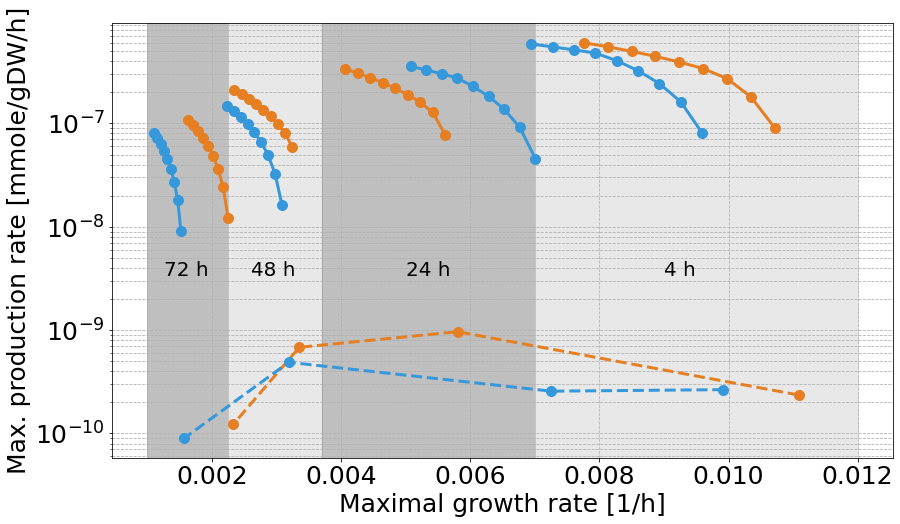

In [374]:
# Create figure and axis
fig, ax = plt.subplots(figsize=(14, 8))

# Dictionary to hold the datasets
datasets = {
    "x_hp_real": x_hp_real, "y_hp_real": y_hp_real,
    "x_lp_real": x_lp_real, "y_lp_real": y_lp_real,
    "x_hp_04": x_hp_04, "y_hp_04": y_hp_04,
    "x_lp_04": x_lp_04, "y_lp_04": y_lp_04,
    "x_hp_24": x_hp_24, "y_hp_24": y_hp_24,
    "x_lp_24": x_lp_24, "y_lp_24": y_lp_24,
    "x_hp_48": x_hp_48, "y_hp_48": y_hp_48,
    "x_lp_48": x_lp_48, "y_lp_48": y_lp_48,
    "x_hp_72": x_hp_72, "y_hp_72": y_hp_72,
    "x_lp_72": x_lp_72, "y_lp_72": y_lp_72
}

# Plot all datasets
for i, (key_x, key_y) in enumerate(zip(list(datasets.keys())[::2], list(datasets.keys())[1::2])):
    # Check if the dataset contains '_real' in its name for dashed line style
    linestyle = '--' if '_real' in key_x else '-'
    
    # Assign color based on high producer (hp) or low producer (lp)
    color = "#E67E22" if 'hp' in key_x else "#3498DB"
    
    # Plot the dataset with appropriate linestyle and color
    ax.plot(datasets[key_x], datasets[key_y], 'o-', color=color, linestyle=linestyle, 
            markersize=10, linewidth=3, label=key_x)

# Set log scale for y-axis
ax.set_yscale('log')

# Labeling axes
plt.xlabel('Maximal growth rate [1/h]', fontsize=25)  # Set x-axis label font size
plt.ylabel('Max. production rate [mmole/gDW/h]', fontsize=25)  # Set y-axis label font size
plt.xticks(fontsize=25)  # Increase the font size of x-ticks
plt.yticks(fontsize=25)  # Increase the font size of y-ticks

# Adding vertical shaded regions to mimic the original image
ax.axvspan(0.001, 0.00225, color='gray', alpha=0.5)
ax.axvspan(0.00225, 0.0037, color='lightgray', alpha=0.5)
ax.axvspan(0.0037, 0.007, color='gray', alpha=0.5)
ax.axvspan(0.007, 0.012, color='lightgray', alpha=0.5)

# Adding text annotations
ax.text(0.00125, 3.8e-9, '72 h', rotation=0, verticalalignment='center', color='black', fontsize = 20)
ax.text(0.0026, 3.8e-9, '48 h', rotation=0, verticalalignment='center', color='black', fontsize = 20)
ax.text(0.005, 3.8e-9, '24 h', rotation=0, verticalalignment='center', color='black', fontsize = 20)
ax.text(0.009, 3.8e-9, '4 h', rotation=0, verticalalignment='center', color='black', fontsize = 20)

# Show legend
#ax.legend()

# Show grid for better visualization
ax.grid(True, which="both", ls="--")

plt.savefig('/home/users/lzehetner/data/hek/plots/prod_env.png')

# Display the plot
plt.show()